In [1]:
import os
import logging as log
from time import strftime
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
from utils.data_processing import *
from logger.logger import setup_logging
from utils.configs import BaseConf
from utils.utils import write_json, Timer
from models.kangkang_fnn_models import KangFeedForwardNetwork
from models.hawkes_model import HawkesModelGeneral, IndHawkesModel
from dataloaders.flat_loader import FlatDataLoaders
from datasets.flat_dataset import FlatDataGroup

from dataloaders.grid_loader import GridDataLoaders
from datasets.grid_dataset import GridDataGroup

from dataloaders.cell_loader import CellDataLoaders
from datasets.cell_dataset import CellDataGroup


from utils.plots import DistributionPlotter
from utils.metrics import PRCurvePlotter, ROCCurvePlotter, LossPlotter, CellPlotter
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score, classification_report
import pickle
from utils.utils import pshape, pmax, pmin, pmean, get_data_sub_paths
import os

%matplotlib inline
from utils.mock_data import mock_fnn_data_classification
import matplotlib.pyplot as plt
from utils.plots import im
from utils.metrics import best_threshold, get_y_pred
from models.model_result import ModelResult, ModelMetrics, save_metrics, compare_models,\
                                get_models_metrics, get_models_results, get_metrics_table, get_all_metrics
from models.baseline_models import ExponentialMovingAverage, UniformMovingAverage, \
                                    TriangularMovingAverage, HistoricAverage

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [12]:
data_sub_paths = get_data_sub_paths()
np.sort(data_sub_paths)



array(['T12H-X850M-Y880M_2013-01-01_2017-01-01',
       'T1H-X1700M-Y1760M_2013-01-01_2017-01-01',
       'T24H-X255M-Y220M_2013-01-01_2017-01-01',
       'T24H-X425M-Y440M_2013-01-01_2017-01-01',
       'T24H-X850M-Y880M_2013-01-01_2017-01-01',
       'T24H-X85M-Y110M_2013-01-01_2017-01-01',
       'T3H-X850M-Y880M_2013-01-01_2017-01-01',
       'T6H-X850M-Y880M_2013-01-01_2017-01-01'], dtype='<U39')

In [15]:
# run HAWKES INDEPENDENT MODEL for all data dimensions
for data_sub_path in data_sub_paths:
    conf = BaseConf()
    
    conf.data_path = f"./data/processed/{data_sub_path}/"
    setup_logging(save_dir=conf.data_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    
    log.info("\n===================================================="+\
             "===============================================================\n" + \
             f"CALCULATING BASE LINE RESULTS FOR {data_sub_path}\n"+\
            "=============================================================="+\
             "=====================================================")

    if not os.path.exists(conf.data_path):
        raise Exception(f"Directory ({conf.data_path}) needs to exist.")

    # LOAD DATA
    conf.shaper_threshold = 0
    conf.shaper_top_k = -1
    data_group = FlatDataGroup(data_path=conf.data_path, conf=conf)
    loaders = FlatDataLoaders(data_group=data_group, conf=conf)    
        
    # ------------ HAWKES INDEPENDENT MODEL
    conf.model_name = f"Ind-Hawkes Model"  # tod add the actual parameters as well
    conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
    os.makedirs(conf.model_path, exist_ok=True)
    setup_logging(save_dir=conf.model_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    
    log.info("=====================================BEGIN=====================================")
    test_set_size = data_group.testing_set.target_shape[0]

    trn_crimes = data_group.training_set.crimes[:,0]
    trn_y_true = data_group.training_set.targets

    tst_crimes = data_group.testing_set.crimes[:,0]
    tst_y_true = data_group.testing_set.targets
    tst_t_range = data_group.testing_set.t_range

    # time step in this context is used for 
    freqstr = data_group.t_range.freqstr
    if freqstr == "H":
        freqstr = "1H"
    time_step = int(24 / int(freqstr[:freqstr.find("H")]))

    kernel_size = time_step*30

    N,L = np.shape(trn_crimes)

    model = IndHawkesModel(kernel_size=kernel_size)
    trn_probas_pred = model.fit_transform(trn_crimes)

    thresh = best_threshold(y_true=trn_y_true,
                            probas_pred=trn_probas_pred)

    tst_probas_pred = model.transform(tst_crimes)
    tst_y_pred = get_y_pred(thresh, tst_probas_pred)

    tst_y_true = tst_y_true[-test_set_size:]
    tst_y_pred = tst_y_pred[-test_set_size:]
    tst_y_pred = np.expand_dims(tst_y_pred, axis=1)
    tst_probas_pred = tst_probas_pred[-test_set_size:]
    tst_probas_pred = np.expand_dims(tst_probas_pred, axis=1)
    tst_t_range = tst_t_range[-test_set_size:]

    save_metrics(y_true=tst_y_true,
                 y_pred=tst_y_pred,
                 probas_pred=tst_probas_pred,
                 t_range=tst_t_range,
                 shaper=data_group.shaper,                
                 conf=conf)  
    
    # ------------HAWKES INDEPENDENT MODEL    

2019-12-01T09:39:29 | root | INFO | 
CALCULATING BASE LINE RESULTS FOR T3H-X850M-Y880M_2013-01-01_2017-01-01
2019-12-01T09:39:30 | root | INFO | 	t_range shape (11689,)
fitted historic average: step (8) and max_steps (-1)
2019-12-01T09:40:07 | root | INFO | =====================================BEGIN=====================================
2019-12-01T09:40:38 | root | INFO | f1_score: 0.30008989434850525 at index 2161679, new threshold 0.05151080261196153
2019-12-01T09:40:43 | root | INFO | 
        MODEL METRICS
            Model Name: Ind-Hawkes Model
                MAE:                0.10648864066895862
                RMSE:               0.28007040620136325
                ROC AUC:            0.7239514538873473                
                Average Precision:  0.20999954831830273
                Precision:          0.19818159822068362
                Recall:             0.4395640686922061
                Accuracy:           0.7985532341563317
                MCC:                0.1

In [16]:
# run HAWKES GENERAL MODEL for all data dimensions
for data_sub_path in data_sub_paths:
    conf = BaseConf()
    
    conf.data_path = f"./data/processed/{data_sub_path}/"
    setup_logging(save_dir=conf.data_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    
    log.info("\n===================================================="+\
             "===============================================================\n" + \
             f"CALCULATING BASE LINE RESULTS FOR {data_sub_path}\n"+\
            "=============================================================="+\
             "=====================================================")

    if not os.path.exists(conf.data_path):
        raise Exception(f"Directory ({conf.data_path}) needs to exist.")

    # LOAD DATA
    conf.shaper_threshold = 0
    conf.shaper_top_k = -1
    data_group = FlatDataGroup(data_path=conf.data_path, conf=conf)
    loaders = FlatDataLoaders(data_group=data_group, conf=conf)    
        
    # ------------ HAWKES GENERAL MODEL
    conf.model_name = f"Hawkes General Model"  # tod add the actual parameters as well
    conf.model_path = conf.data_path + f"models/{conf.model_name}/"
    os.makedirs(conf.model_path, exist_ok=True)
    setup_logging(save_dir=conf.model_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    
    log.info("=====================================BEGIN=====================================")
    test_set_size = data_group.testing_set.target_shape[0]

    trn_crimes = data_group.training_set.crimes[:,0]
    trn_y_true = data_group.training_set.targets

    tst_crimes = data_group.testing_set.crimes[:,0]
    tst_y_true = data_group.testing_set.targets
    tst_t_range = data_group.testing_set.t_range

    # time step in this context is used for 
    freqstr = data_group.t_range.freqstr
    if freqstr == "H":
        freqstr = "1H"
    time_step = int(24 / int(freqstr[:freqstr.find("H")]))

    kernel_size = time_step*30

    N,L = np.shape(trn_crimes)

    model = HawkesModelGeneral(kernel_size=kernel_size)
    trn_probas_pred = model.fit_transform(trn_crimes)

    thresh = best_threshold(y_true=trn_y_true,
                            probas_pred=trn_probas_pred)

    tst_probas_pred = model.transform(tst_crimes)
    tst_y_pred = get_y_pred(thresh, tst_probas_pred)

    tst_y_true = tst_y_true[-test_set_size:]
    tst_y_pred = tst_y_pred[-test_set_size:]
    tst_y_pred = np.expand_dims(tst_y_pred, axis=1)
    tst_probas_pred = tst_probas_pred[-test_set_size:]
    tst_probas_pred = np.expand_dims(tst_probas_pred, axis=1)
    tst_t_range = tst_t_range[-test_set_size:]

    save_metrics(y_true=tst_y_true,
                 y_pred=tst_y_pred,
                 probas_pred=tst_probas_pred,
                 t_range=tst_t_range,
                 shaper=data_group.shaper,                
                 conf=conf)  
    
    # ------------HAWKES GENERAL MODEL    

2019-12-01T09:40:43 | root | INFO | 
CALCULATING BASE LINE RESULTS FOR T3H-X850M-Y880M_2013-01-01_2017-01-01
2019-12-01T09:40:43 | root | INFO | 	t_range shape (11689,)
fitted historic average: step (8) and max_steps (-1)
2019-12-01T09:41:19 | root | INFO | =====================================BEGIN=====================================
2019-12-01T09:41:21 | root | INFO | f1_score: 0.24249561475678702 at index 95046, new threshold 0.021633427781004917
2019-12-01T09:41:26 | root | INFO | 
        MODEL METRICS
            Model Name: Hawkes General Model
                MAE:                0.09597068483245312
                RMSE:               0.28764296779007203
                ROC AUC:            0.6759030956953385                
                Average Precision:  0.17154225634119127
                Precision:          0.1644289935100464
                Recall:             0.40319517833553503
                Accuracy:           0.7721246017749459
                MCC:                

2019-12-01T09:41:26 | root | INFO | 
CALCULATING BASE LINE RESULTS FOR T3H-X850M-Y880M_2013-01-01_2017-01-01
=================================================================t==================================================
2019-12-01T09:41:26 | root | INFO | =====================================BEGIN=====================================
2019-12-01T09:41:26 | root | INFO | 	t_range shape (11689,)
fitted historic average: step (8) and max_steps (-1)
2019-12-01T09:41:57 | root | INFO | class distribution: {0.0: 0.9084856328321289, 1.0: 0.09151436716787106}


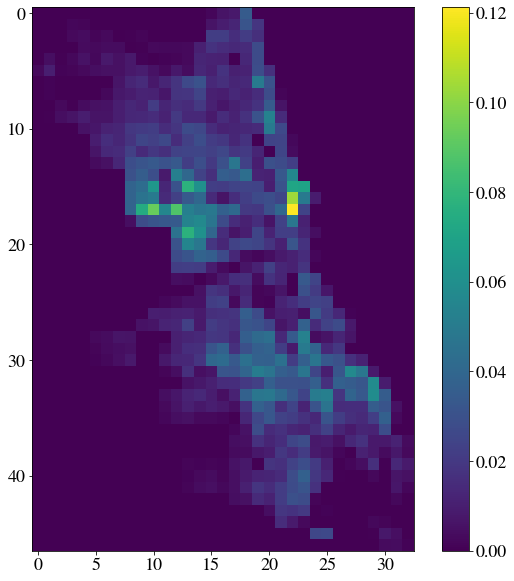

2019-12-01T09:41:58 | root | INFO | =====================================BEGIN=====================================
2019-12-01T09:41:58 | root | INFO | using time step: 8
fitted historic average: step (8) and max_steps (-1)
fitted historic average: step (8) and max_steps (-1)
2019-12-01T09:42:23 | root | INFO | f1_score: 0.30971838641368066 at index 250801, new threshold 0.03342723004694832
2019-12-01T09:42:23 | root | INFO | ======== ./data/processed/T3H-X850M-Y880M_2013-01-01_2017-01-01/models/Historic Average/  ========
2019-12-01T09:42:27 | root | INFO | 
        MODEL METRICS
            Model Name: Historic Average
                MAE:                0.0988761754761451
                RMSE:               0.2843915893252914
                ROC AUC:            0.7448873651951392                
                Average Precision:  0.22770742362622737
                Precision:          0.2202328730029786
                Recall:             0.4196870871862616
                Accuracy

In [17]:
# run base line models for all data dimensions
for data_sub_path in data_sub_paths:
    conf = BaseConf()
  
    conf.data_path = f"./data/processed/{data_sub_path}/"
    
    setup_logging(save_dir=conf.data_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    log.info("\n===================================================="+\
             "===============================================================\n" + \
             f"CALCULATING BASE LINE RESULTS FOR {data_sub_path}\n"+\
            "=============================================================="+\
             "===t==================================================")

    log.info("=====================================BEGIN=====================================")

    if not os.path.exists(conf.data_path):
        raise Exception(f"Directory ({conf.data_path}) needs to exist.")

    # DATA LOADER SETUP
    np.random.seed(conf.seed)

    conf.shaper_threshold = 0
    conf.shaper_top_k = -1

    # CRIME DATA
    data_group = FlatDataGroup(data_path=conf.data_path, conf=conf)
    loaders = FlatDataLoaders(data_group=data_group, conf=conf)    
    
    # LOG CLASS DISTRIBUTION
    vals, counts = np.unique(data_group.targets,return_counts=True)
    counts = counts/np.sum(counts)
    dist = dict(zip(vals,counts))
    log.info(f"class distribution: {dist}")

    test_set_size = data_group.testing_set.target_shape[0]
    crimes = data_group.shaper.unsqueeze(data_group.crimes)
    im(crimes.mean(0)[0])
    crimes = data_group.crimes
    t_range = data_group.t_range

    # -----------HISTORIC AVERAGE
    # Create model folder and setup logging for model
    conf.model_name = "Historic Average"  # needs to be created
    conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
    os.makedirs(conf.model_path, exist_ok=True)
    setup_logging(save_dir=conf.model_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    log.info("=====================================BEGIN=====================================")

    # time step in this context is used for 
    freqstr = t_range.freqstr
    if freqstr == "H":
        freqstr = "1H"
    time_step = int(24 / int(freqstr[:freqstr.find("H")]))
        
    log.info(f"using time step: {time_step}")

    test_set_size = data_group.testing_set.target_shape[0]

    ha = HistoricAverage(step=time_step)
    all_crimes = data_group.crimes[:,0]
    all_targets = data_group.targets
    all_crimes_ha = ha.fit_transform(data_group.crimes[:,0:1])[:,0]
    
    ha.fit(data_group.crimes[:,0:1])
#     ha.max_steps = -1
    all_crimes_ha = ha.transform(data_group.crimes[:,0:1])[:,0]
    
    all_t_range = data_group.t_range

    tst_crimes_ha = all_crimes_ha[-test_set_size:]
    tst_targets = all_targets[-test_set_size:]
    tst_t_range = all_t_range[-test_set_size:]

    trn_probas_pred = all_crimes_ha[time_step+1:-test_set_size] # skip all the nan values
    trn_y_true = all_targets[time_step+1:-test_set_size]

    thresh = best_threshold(trn_y_true, trn_probas_pred) # should only come from the train predictions

    tst_y_true = tst_targets
    tst_probas_pred = tst_crimes_ha
    tst_y_pred = get_y_pred(thresh, tst_probas_pred)  # might want to do this for each cell either?

    tst_y_pred = np.expand_dims(tst_y_pred,axis=1)
    tst_probas_pred = np.expand_dims(tst_probas_pred,axis=1)

    log.info(f"======== {conf.model_path}  ========")
    save_metrics(y_true=tst_y_true,
                 y_pred=tst_y_pred,
                 probas_pred=tst_probas_pred,
                 t_range=tst_t_range,
                 shaper=data_group.shaper,                
                 conf=conf)  

    log.info("=====================================END=====================================\n")
    # -----------HISTORIC AVERAGE

    # -----------GLOBAL AVERAGE
    # Create model folder and setup logging for model
    conf.model_name = "Global Average"  # needs to be created
    conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
    os.makedirs(conf.model_path, exist_ok=True)
    setup_logging(save_dir=conf.model_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    log.info("=====================================BEGIN=====================================")


    test_set_size = data_group.testing_set.target_shape[0]

    all_crimes = data_group.crimes[:,0]
    all_targets = data_group.targets

    trn_crimes = all_crimes[:-test_set_size]
    trn_targets = all_targets[:-test_set_size]

    tst_crimes = all_crimes[-test_set_size:]
    tst_targets = all_targets[-test_set_size:]
    tst_t_range = all_t_range[-test_set_size:]

    trn_mean = np.mean(trn_crimes,axis=0,keepdims=True)  # keep dims used to make scalar product easy
    trn_ones = np.ones_like(trn_crimes,dtype=np.float)
    trn_probas_pred = trn_mean*trn_ones

    thresh = best_threshold(y_true=trn_targets,
                            probas_pred=trn_probas_pred) # should only come from the train predictions

    # only use the training sets - mean
    tst_ones = np.ones_like(tst_crimes,dtype=np.float)
    tst_probas_pred = trn_mean*tst_ones

    tst_y_true = tst_targets
    tst_y_pred = get_y_pred(thresh, tst_probas_pred)  # might want to do this for each cell either?

    tst_y_pred = np.expand_dims(tst_y_pred,axis=1)
    tst_probas_pred = np.expand_dims(tst_probas_pred,axis=1)

    log.info(f"======== {conf.model_path}  ========")
    save_metrics(y_true=tst_y_true,
                 y_pred=tst_y_pred,
                 probas_pred=tst_probas_pred,
                 t_range=tst_t_range,
                 shaper=data_group.shaper,                
                 conf=conf)  

    log.info("=====================================END=====================================\n")
    # -----------GLOBAL AVERAGE
            
    # ------------PREVIOUS TIME STEP
    # Create model folder and setup logging for model
    conf.model_name = "Previous Time Step"  # needs to be created
    conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
    
    os.makedirs(conf.model_path, exist_ok=True)
    setup_logging(save_dir=conf.model_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    
    log.info("=====================================BEGIN=====================================")

    test_set_size = data_group.testing_set.target_shape[0]

    all_probas_pred = data_group.crimes[:,0]
    all_targets = data_group.targets
    all_t_range = data_group.t_range

    tst_probas_pred = all_probas_pred[-test_set_size:]
    tst_targets = all_targets[-test_set_size:]
    tst_t_range = all_t_range[-test_set_size:]

    trn_probas_pred = all_probas_pred[:-test_set_size] # skip all the nan values
    trn_y_true = all_targets[:-test_set_size]

    thresh = best_threshold(trn_y_true, trn_probas_pred) # should only come from the train predictions

    tst_y_true = tst_targets
    tst_y_pred = get_y_pred(thresh, tst_probas_pred)  # might want to do this for each cell either?

    tst_y_pred = np.expand_dims(tst_y_pred,axis=1)
    tst_probas_pred = np.expand_dims(tst_probas_pred,axis=1)
    
    save_metrics(y_true=tst_y_true,
                 y_pred=tst_y_pred,
                 probas_pred=tst_probas_pred,
                 t_range=tst_t_range,
                 shaper=data_group.shaper,                
                 conf=conf)  

    log.info("=====================================END=====================================\n")
    # ------------PREVIOUS TIME STEP
    
#    --------------    --------------    --------------    --------------    --------------    --------------

#     # ------------Uniform Moving Average
#     # Create model folder and setup logging for model
#     conf.model_name = "Uni. Mov. Avg."  # needs to be created
#     conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
    
#     os.makedirs(conf.model_path, exist_ok=True)
#     setup_logging(save_dir=conf.model_path,
#                   log_config='./logger/standard_logger_config.json',
#                   default_level=log.INFO)
#     log.info("=====================================BEGIN=====================================")

#     # time step in this context is used for 
#     freqstr = t_range.freqstr
#     if freqstr == "H":
#         freqstr = "1H"
#     time_step = int(24 / int(freqstr[:freqstr.find("H")]))
#     time_step = 30*time_step

#     log.info(f"using time step: {time_step}")

#     test_set_size = data_group.testing_set.target_shape[0]

#     window_len=time_step

#     ma = UniformMovingAverage(window_len=window_len)

#     all_crimes = data_group.crimes[:,0]
#     all_targets = data_group.targets
#     all_probas_pred = ma(all_crimes)
#     all_t_range = data_group.t_range

#     tst_probas_pred = all_probas_pred[-test_set_size:]
#     tst_targets = all_targets[-test_set_size:]
#     tst_t_range = all_t_range[-test_set_size:]

#     trn_probas_pred = all_probas_pred[time_step+1:-test_set_size] # skip all the nan values
#     trn_y_true = all_targets[time_step+1:-test_set_size]

#     thresh = best_threshold(trn_y_true, trn_probas_pred) # should only come from the train predictions

#     tst_y_true = tst_targets
#     tst_probas_pred = tst_probas_pred
#     tst_y_pred = get_y_pred(thresh, tst_probas_pred)  # might want to do this for each cell either?

#     tst_y_pred = np.expand_dims(tst_y_pred,axis=1)
#     tst_probas_pred = np.expand_dims(tst_probas_pred,axis=1)

#     log.info(f"======== {conf.model_path}  ========")
#     save_metrics(y_true=tst_y_true,
#                  y_pred=tst_y_pred,
#                  probas_pred=tst_probas_pred,
#                  t_range=tst_t_range,
#                  shaper=data_group.shaper,                
#                  conf=conf)  

#     log.info("=====================================END=====================================\n")
#     # ------------Uniform Moving Average
    
#     # ------------Exponential Moving Average
#     # Create model folder and setup logging for model
#     conf.model_name = "Exp. Mov. Avg."  # needs to be created
#     conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
    
#     os.makedirs(conf.model_path, exist_ok=True)
#     setup_logging(save_dir=conf.model_path,
#                   log_config='./logger/standard_logger_config.json',
#                   default_level=log.INFO)
#     log.info("=====================================BEGIN=====================================")

#     # time step in this context is used for 
#     freqstr = t_range.freqstr
#     if freqstr == "H":
#         freqstr = "1H"
#     time_step = int(24 / int(freqstr[:freqstr.find("H")]))
#     time_step = 30*time_step

#     log.info(f"using time step: {time_step}")

#     test_set_size = data_group.testing_set.target_shape[0]

#     alpha=1e-2
#     window_len=time_step

#     ma = ExponentialMovingAverage(alpha=alpha,window_len=window_len)

#     all_crimes = data_group.crimes[:,0]
#     all_targets = data_group.targets
#     all_probas_pred = ma(all_crimes)
#     all_t_range = data_group.t_range

#     tst_probas_pred = all_probas_pred[-test_set_size:]
#     tst_targets = all_targets[-test_set_size:]
#     tst_t_range = all_t_range[-test_set_size:]

#     trn_probas_pred = all_probas_pred[time_step+1:-test_set_size] # skip all the nan values
#     trn_y_true = all_targets[time_step+1:-test_set_size]

#     thresh = best_threshold(trn_y_true, trn_probas_pred) # should only come from the train predictions

#     tst_y_true = tst_targets
#     tst_probas_pred = tst_probas_pred
#     tst_y_pred = get_y_pred(thresh, tst_probas_pred)  # might want to do this for each cell either?

#     tst_y_pred = np.expand_dims(tst_y_pred,axis=1)
#     tst_probas_pred = np.expand_dims(tst_probas_pred,axis=1)

#     log.info(f"======== {conf.model_path}  ========")
#     save_metrics(y_true=tst_y_true,
#                  y_pred=tst_y_pred,
#                  probas_pred=tst_probas_pred,
#                  t_range=tst_t_range,
#                  shaper=data_group.shaper,                
#                  conf=conf)  

#     log.info("=====================================END=====================================\n")
#     # ------------Exponential Moving Average
    
#     # ------------Triangular Moving Average
#     # Create model folder and setup logging for model
#     conf.model_name = "Tri. Mov. Avg."  # needs to be created
#     conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
    
#     os.makedirs(conf.model_path, exist_ok=True)
#     setup_logging(save_dir=conf.model_path,
#                   log_config='./logger/standard_logger_config.json',
#                   default_level=log.INFO)
#     log.info("=====================================BEGIN=====================================")

#     # time step in this context is used for 
#     freqstr = t_range.freqstr
#     if freqstr == "H":
#         freqstr = "1H"
#     time_step = int(24 / int(freqstr[:freqstr.find("H")]))
#     time_step = 30*time_step

#     log.info(f"using time step: {time_step}")

#     test_set_size = data_group.testing_set.target_shape[0]

#     window_len=time_step

#     ma = TriangularMovingAverage(window_len=window_len)

#     all_crimes = data_group.crimes[:,0]
#     all_targets = data_group.targets
#     all_probas_pred = ma(all_crimes)
#     all_t_range = data_group.t_range

#     tst_probas_pred = all_probas_pred[-test_set_size:]
#     tst_targets = all_targets[-test_set_size:]
#     tst_t_range = all_t_range[-test_set_size:]

#     trn_probas_pred = all_probas_pred[time_step+1:-test_set_size] # skip all the nan values
#     trn_y_true = all_targets[time_step+1:-test_set_size]

#     thresh = best_threshold(trn_y_true, trn_probas_pred) # should only come from the train predictions

#     tst_y_true = tst_targets
#     tst_probas_pred = tst_probas_pred
#     tst_y_pred = get_y_pred(thresh, tst_probas_pred)  # might want to do this for each cell either?

#     tst_y_pred = np.expand_dims(tst_y_pred,axis=1)
#     tst_probas_pred = np.expand_dims(tst_probas_pred,axis=1)

#     log.info(f"======== {conf.model_path}  ========")
#     save_metrics(y_true=tst_y_true,
#                  y_pred=tst_y_pred,
#                  probas_pred=tst_probas_pred,
#                  t_range=tst_t_range,
#                  shaper=data_group.shaper,                
#                  conf=conf)  

#     log.info("=====================================END=====================================\n")
#     # ------------Triangular Moving Average

In [9]:
from models.model_result import compare_all_models

2019-12-01T08:04:04 | root | INFO | T1H-X1700M-Y1760M_2013-01-01_2017-01-01

2019-12-01T08:04:04 | root | INFO | 
                          RMSE       MAE   ROC AUC  Avg. Precision  Precision  \
Model Name                                                                      
Historic Average      0.307219  0.115530  0.747916        0.251100   0.237131   
Ind-Hawkes Model      0.303955  0.120553  0.734573        0.242240   0.221675   
Hawkes General Model  0.308475  0.115534  0.720364        0.225143   0.206355   
Global Average        0.308343  0.116342  0.726534        0.218657   0.202823   
Previous Time Step    0.312521  0.114004  0.548897        0.119208   0.188911   

                        Recall  F1 Score  Accuracy  Matthews Corrcoef  
Model Name                                                             
Historic Average      0.471088  0.315466  0.792826           0.225921  
Ind-Hawkes Model      0.497069  0.306612  0.772178           0.216239  
Hawkes General Model  0.496622

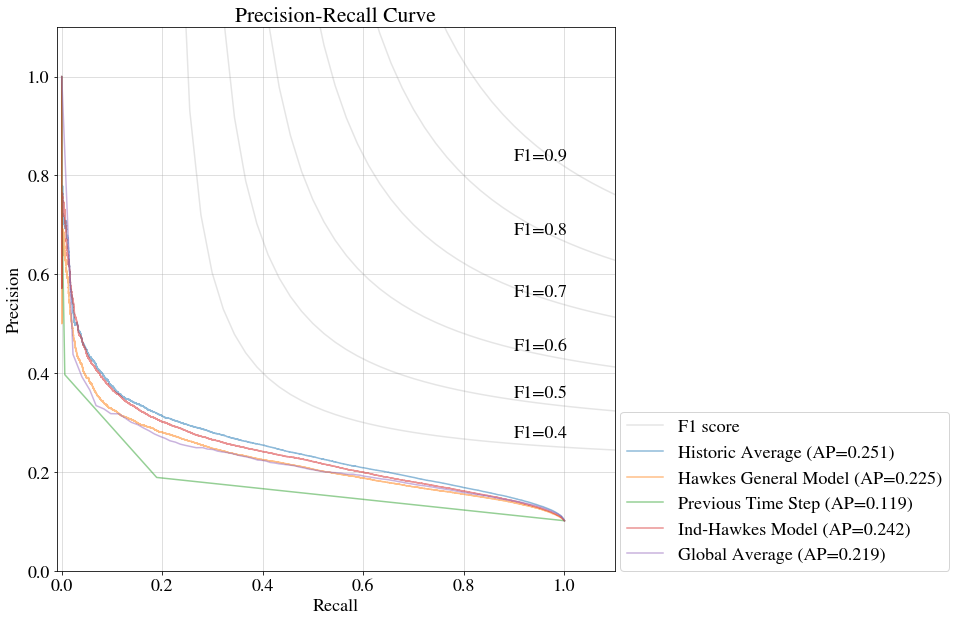

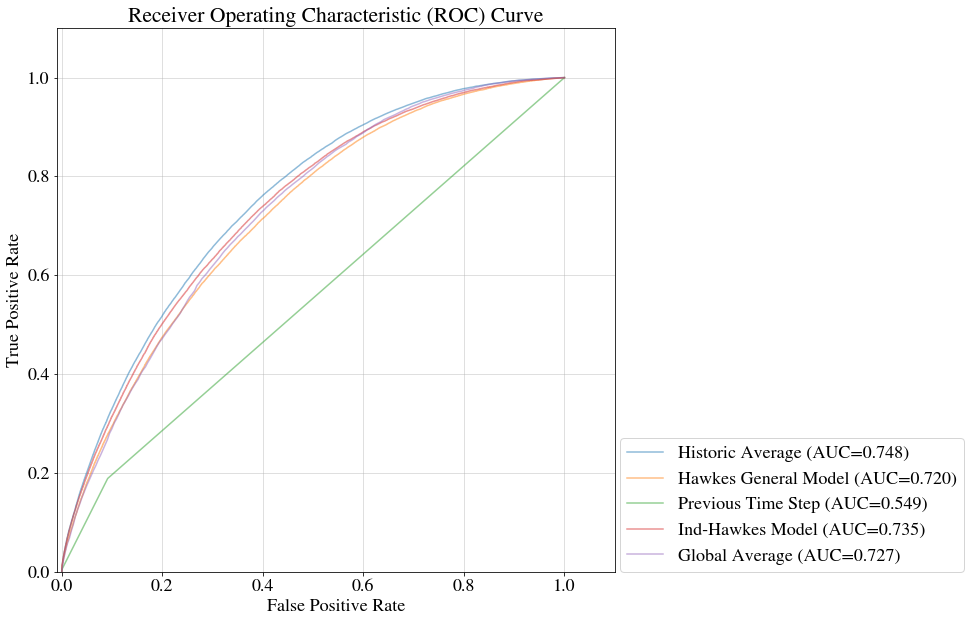

2019-12-01T08:04:05 | root | INFO | T24H-X85M-Y110M_2013-01-01_2017-01-01

2019-12-01T08:04:05 | root | INFO | 
                          RMSE       MAE   ROC AUC  Avg. Precision  Precision  \
Model Name                                                                      
Historic Average      0.194834  0.045725  0.678568        0.106242   0.136494   
Ind-Hawkes Model      0.191179  0.062263  0.670192        0.106072   0.121125   
Global Average        0.194839  0.045719  0.678380        0.105010   0.123895   
Previous Time Step    0.198098  0.045507  0.522427        0.043107   0.081938   
Hawkes General Model  0.195016  0.051735  0.517370        0.041753   0.072216   

                        Recall  F1 Score  Accuracy  Matthews Corrcoef  
Model Name                                                             
Historic Average      0.194953  0.160568  0.920577           0.122352  
Ind-Hawkes Model      0.242440  0.161542  0.901940           0.123485  
Global Average        0.227582  

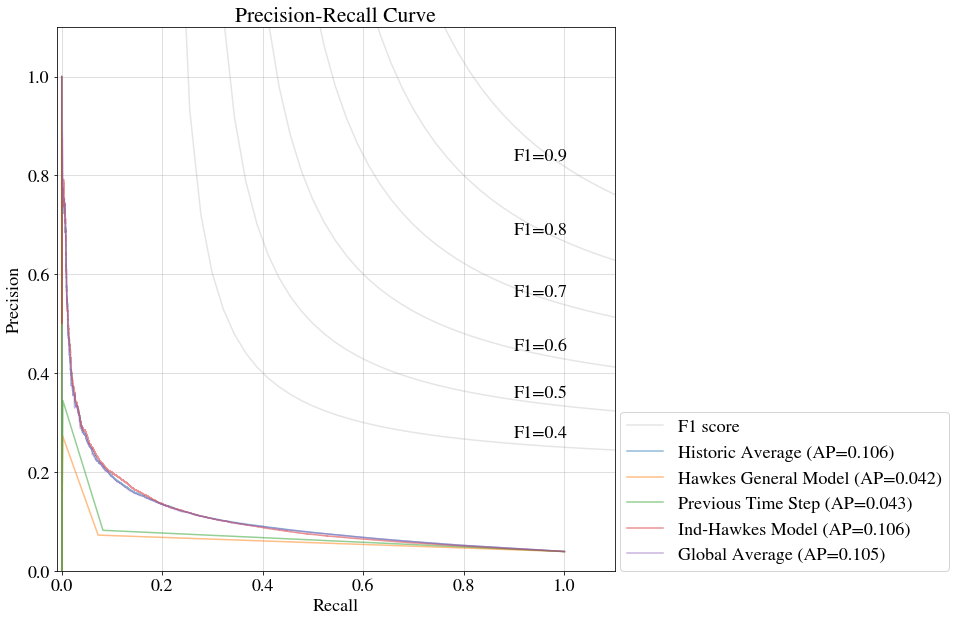

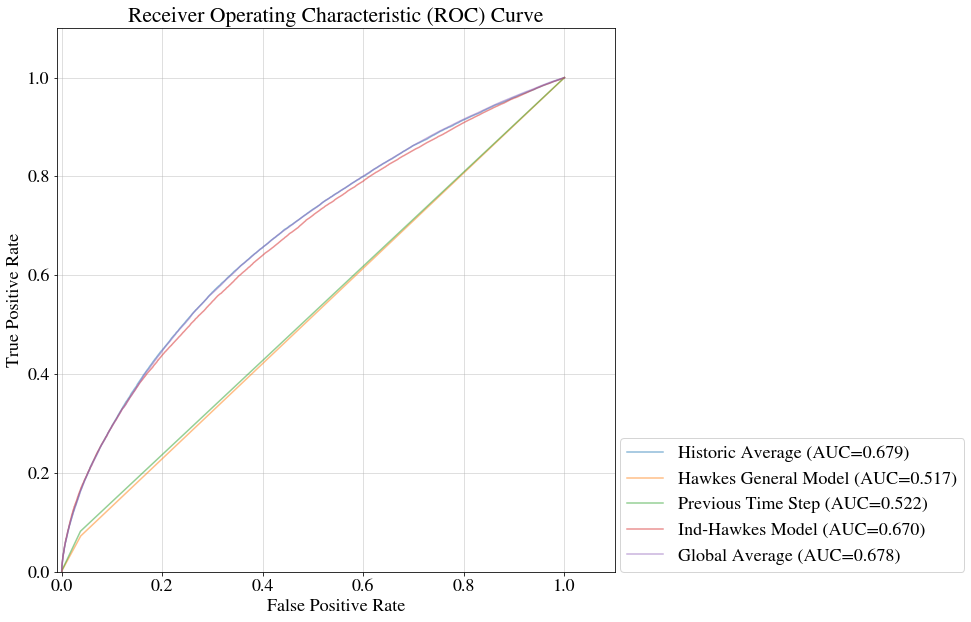

2019-12-01T08:04:06 | root | INFO | T24H-X850M-Y880M_2013-01-01_2017-01-01

2019-12-01T08:04:06 | root | INFO | 
                          RMSE       MAE   ROC AUC  Avg. Precision  Precision  \
Model Name                                                                      
Historic Average      0.572850  0.420800  0.780020        0.732161   0.602188   
Global Average        0.572785  0.420775  0.779824        0.731348   0.595091   
Ind-Hawkes Model      0.440396  0.367043  0.778644        0.730800   0.601035   
Hawkes General Model  0.612081  0.438873  0.747493        0.699312   0.570855   
Previous Time Step    0.585714  0.420469  0.638872        0.551308   0.444358   

                        Recall  F1 Score  Accuracy  Matthews Corrcoef  
Model Name                                                             
Historic Average      0.824669  0.696084  0.680010           0.396018  
Global Average        0.840814  0.696928  0.675046           0.394007  
Ind-Hawkes Model      0.824992 

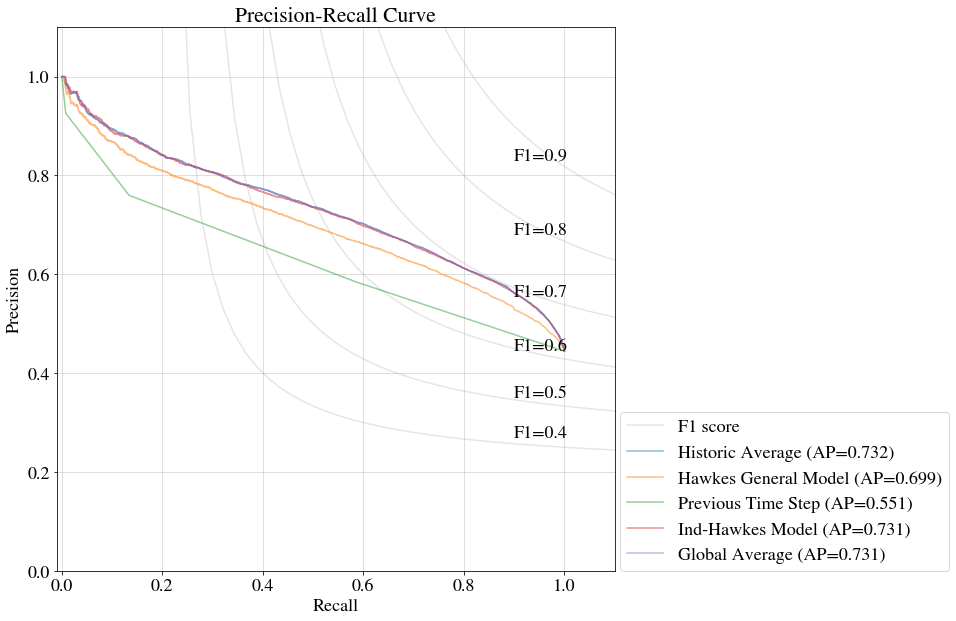

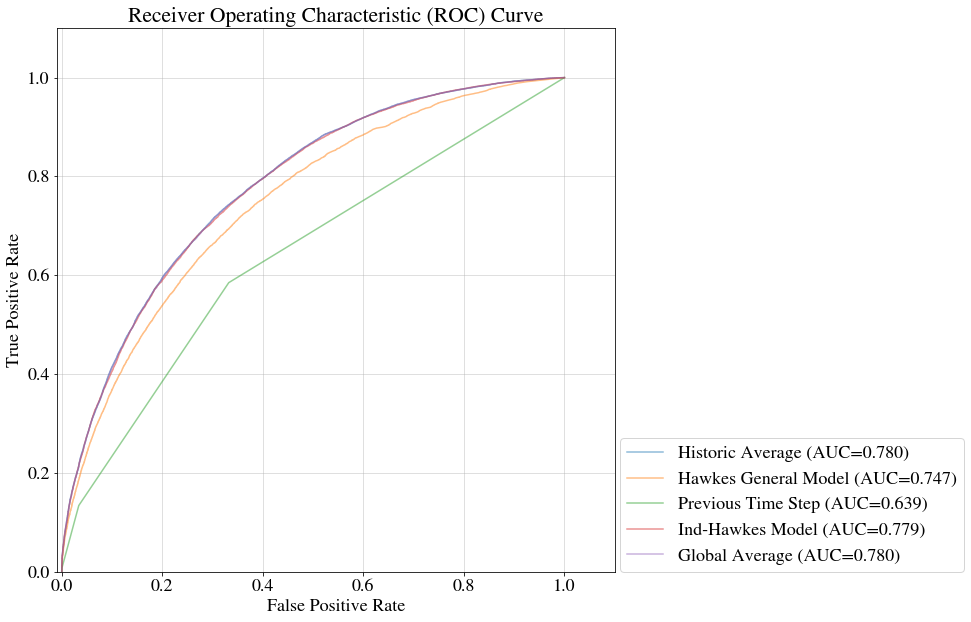

2019-12-01T08:04:06 | root | INFO | T24H-X425M-Y440M_2013-01-01_2017-01-01

2019-12-01T08:04:06 | root | INFO | 
                          RMSE       MAE   ROC AUC  Avg. Precision  Precision  \
Model Name                                                                      
Historic Average      0.404222  0.201424  0.724239        0.387803   0.331032   
Ind-Hawkes Model      0.369121  0.242405  0.721960        0.386764   0.322792   
Global Average        0.404216  0.201455  0.723714        0.386574   0.323375   
Hawkes General Model  0.410653  0.201747  0.652874        0.311993   0.244397   
Previous Time Step    0.411332  0.199237  0.564535        0.219742   0.183744   

                        Recall  F1 Score  Accuracy  Matthews Corrcoef  
Model Name                                                             
Historic Average      0.568350  0.418381  0.709648           0.258186  
Ind-Hawkes Model      0.595151  0.418566  0.696187           0.256999  
Global Average        0.591437 

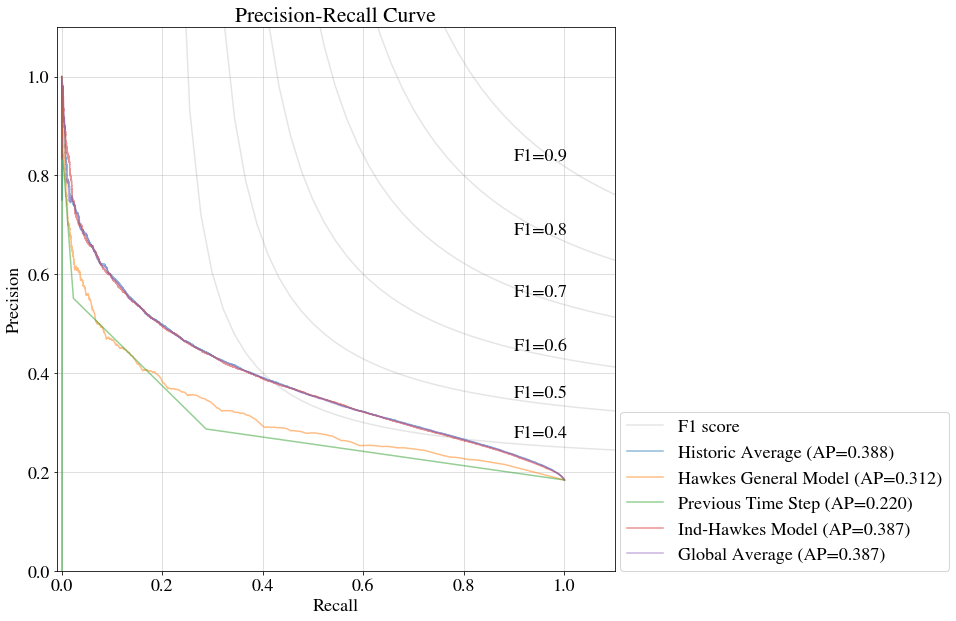

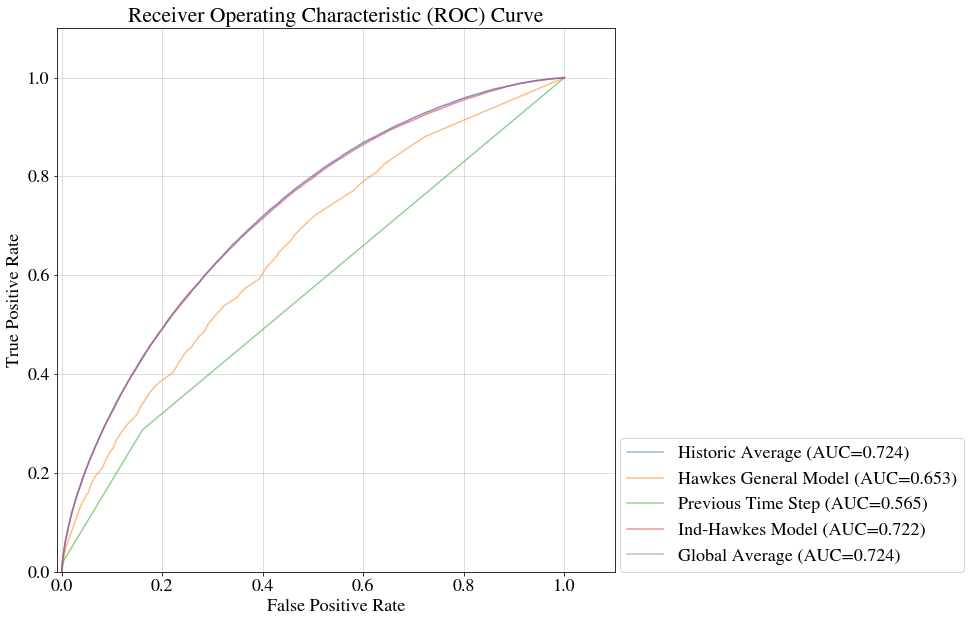

2019-12-01T08:04:07 | root | INFO | T6H-X850M-Y880M_2013-01-01_2017-01-01

2019-12-01T08:04:07 | root | INFO | 
                          RMSE       MAE   ROC AUC  Avg. Precision  Precision  \
Model Name                                                                      
Historic Average      0.376450  0.174459  0.749702        0.366188   0.326010   
Ind-Hawkes Model      0.356522  0.196650  0.733544        0.340464   0.300554   
Global Average        0.377937  0.175758  0.732824        0.334605   0.296068   
Hawkes General Model  0.384124  0.171221  0.690858        0.299927   0.266134   
Previous Time Step    0.385118  0.174045  0.555739        0.184416   0.158169   

                        Recall  F1 Score  Accuracy  Matthews Corrcoef  
Model Name                                                             
Historic Average      0.553760  0.410406  0.748341           0.278787  
Ind-Hawkes Model      0.576403  0.395094  0.720833           0.257479  
Global Average        0.587612  

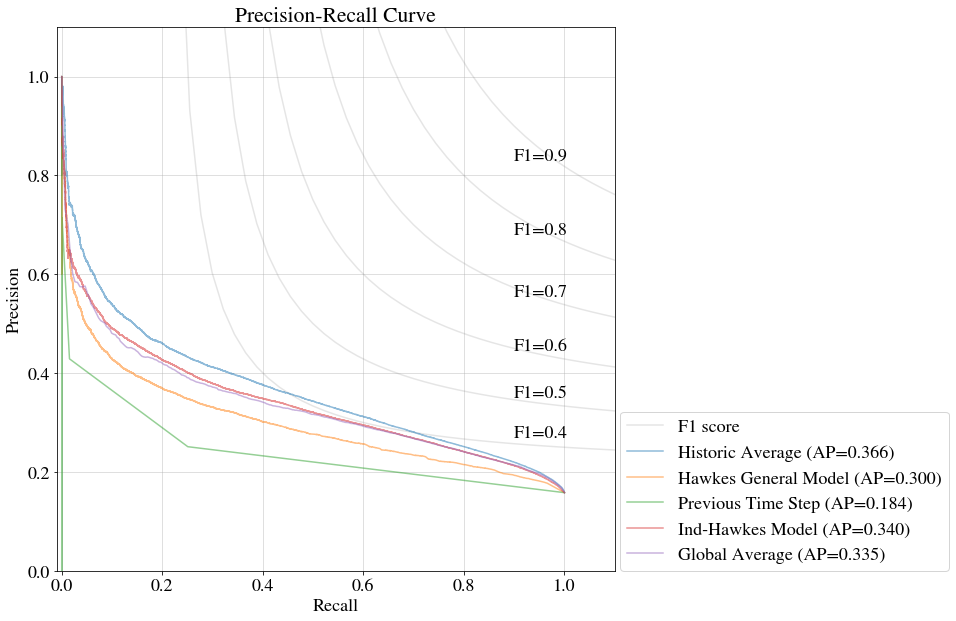

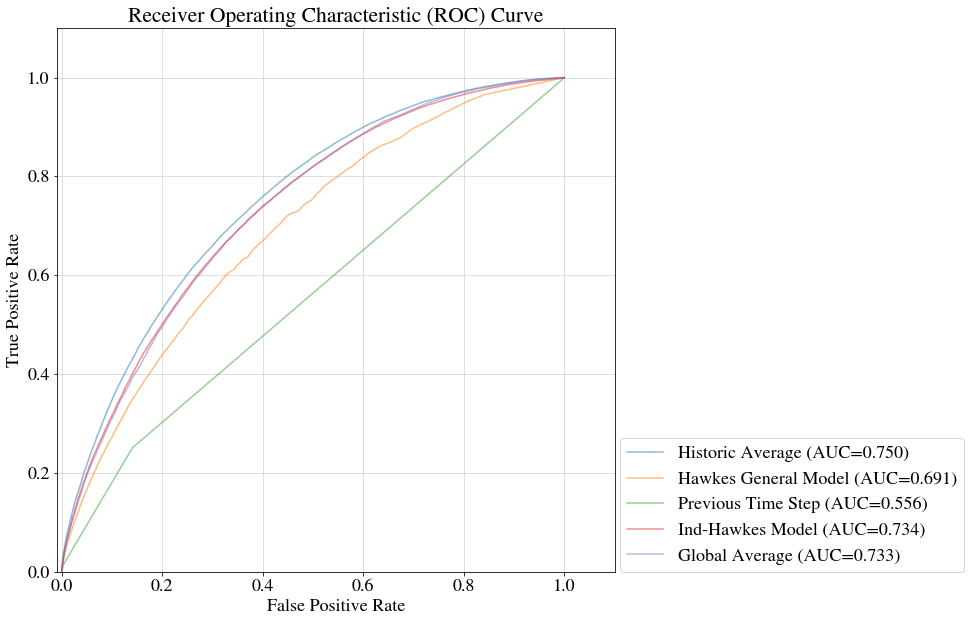

2019-12-01T08:04:08 | root | INFO | T24H-X255M-Y220M_2013-01-01_2017-01-01

2019-12-01T08:04:08 | root | INFO | 
                          RMSE       MAE   ROC AUC  Avg. Precision  Precision  \
Model Name                                                                      
Ind-Hawkes Model      0.270753  0.126706  0.695080        0.201326   0.191432   
Historic Average      0.281573  0.096924  0.699529        0.200813   0.202440   
Global Average        0.281575  0.096949  0.698805        0.199464   0.189847   
Hawkes General Model  0.284096  0.098522  0.549794        0.101060   0.130314   
Previous Time Step    0.286331  0.095486  0.536301        0.095123   0.083706   

                        Recall  F1 Score  Accuracy  Matthews Corrcoef  
Model Name                                                             
Ind-Hawkes Model      0.390051  0.256820  0.811038           0.176385  
Historic Average      0.352217  0.257106  0.829622           0.177008  
Global Average        0.392093 

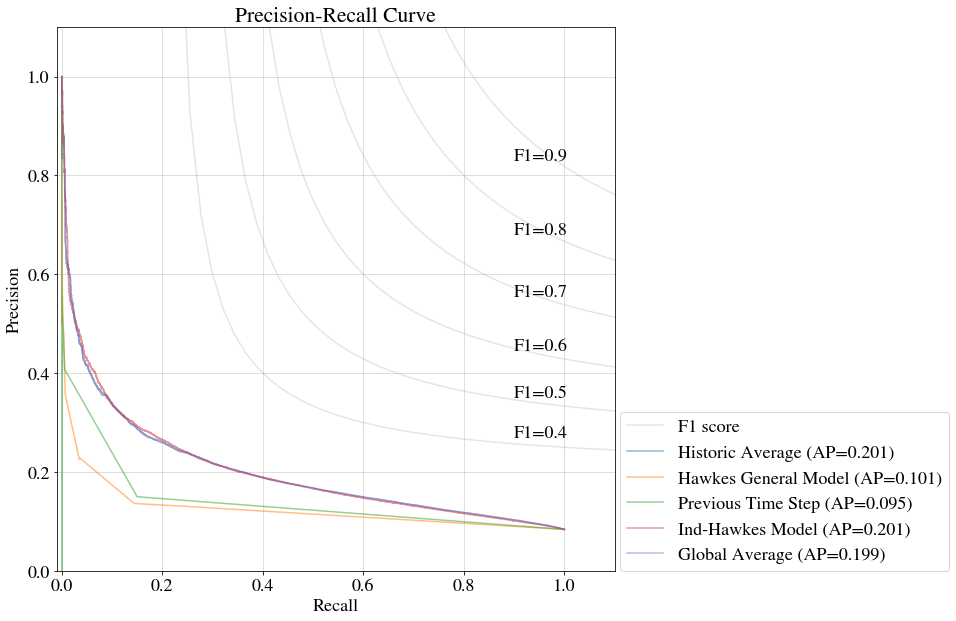

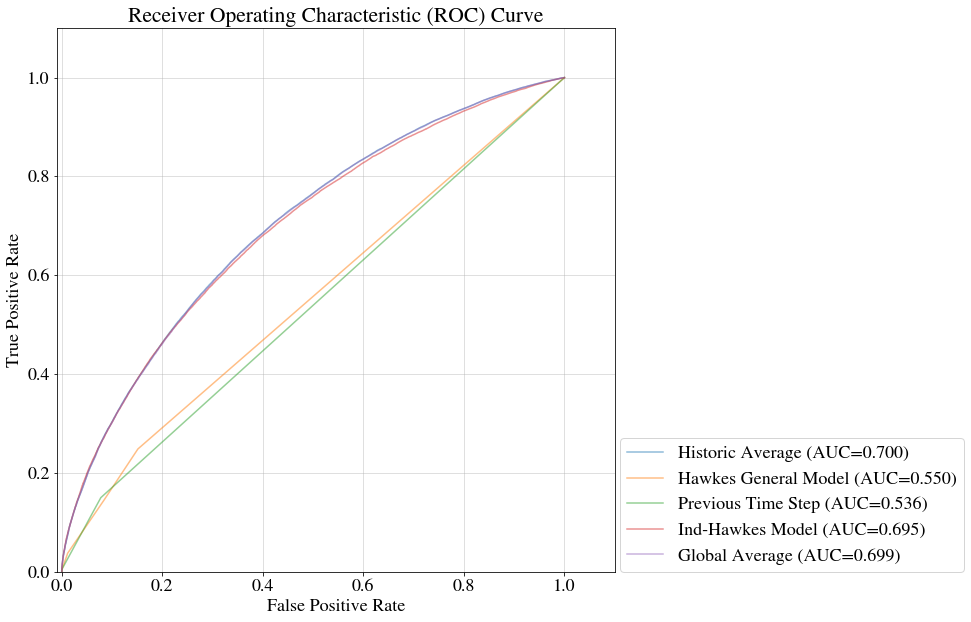

2019-12-01T08:04:09 | root | INFO | T12H-X850M-Y880M_2013-01-01_2017-01-01

2019-12-01T08:04:09 | root | INFO | 
                          RMSE       MAE   ROC AUC  Avg. Precision  Precision  \
Model Name                                                                      
Historic Average      0.477721  0.284863  0.762453        0.550892   0.455744   
Ind-Hawkes Model      0.420386  0.306327  0.749783        0.526836   0.438864   
Global Average        0.479707  0.287101  0.749095        0.524136   0.434399   
Hawkes General Model  0.495772  0.285839  0.721227        0.498410   0.400615   
Previous Time Step    0.491543  0.287400  0.578435        0.324878   0.275233   

                        Recall  F1 Score  Accuracy  Matthews Corrcoef  
Model Name                                                             
Historic Average      0.698255  0.551518  0.687443           0.345121  
Ind-Hawkes Model      0.709303  0.542234  0.670376           0.327950  
Global Average        0.719650 

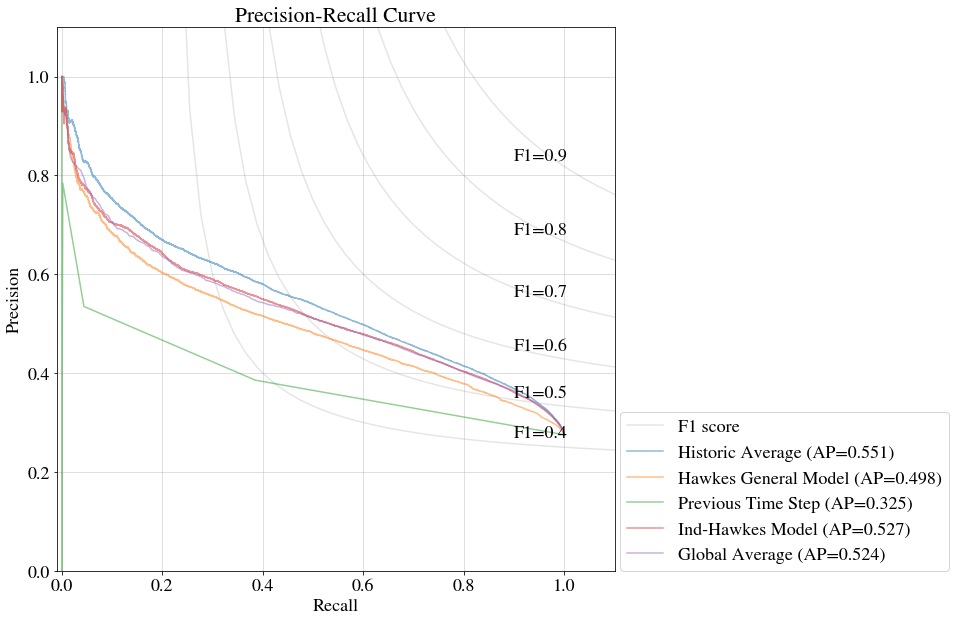

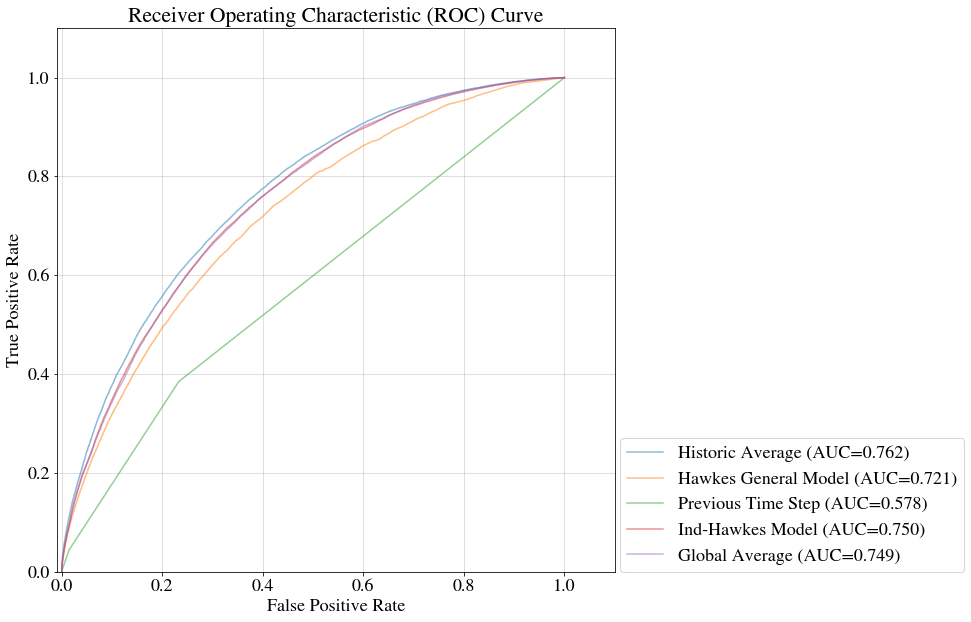

In [10]:
# data_path = conf.model_path[:conf.model_path.find("models")]
for data_sub_path in data_sub_paths:
    log.info(f"{data_sub_path}\n")
    data_path = f"./data/processed/{data_sub_path}/"

    compare_all_models(data_path)

## Old results from 2013 - 2015 datasets

2019-11-21T15:55:16 | root | INFO | T3H-X850M-Y880M_2013-01-01_2015-01-01

2019-11-21T15:55:16 | root | INFO | 
                          RMSE       MAE   ROC AUC  Avg. Precision  Precision  \
Model Name                                                                      
Historic Average      0.283209  0.106314  0.753655        0.246152   0.227663   
Ind-Hawkes Model      0.280383  0.112845  0.732139        0.229116   0.213769   
Global Average        0.284799  0.107550  0.731417        0.210336   0.193046   
Hawkes General Model  0.285977  0.105843  0.699702        0.189770   0.186427   
Previous Time Step    0.294179  0.104064  0.545570        0.105401   0.170390   

                        Recall  F1 Score  Accuracy  Matthews Corrcoef  
Model Name                                                             
Historic Average      0.452580  0.302938  0.816567           0.226921  
Ind-Hawkes Model      0.426486  0.284791  0.811342           0.204780  
Global Average        0.487095  

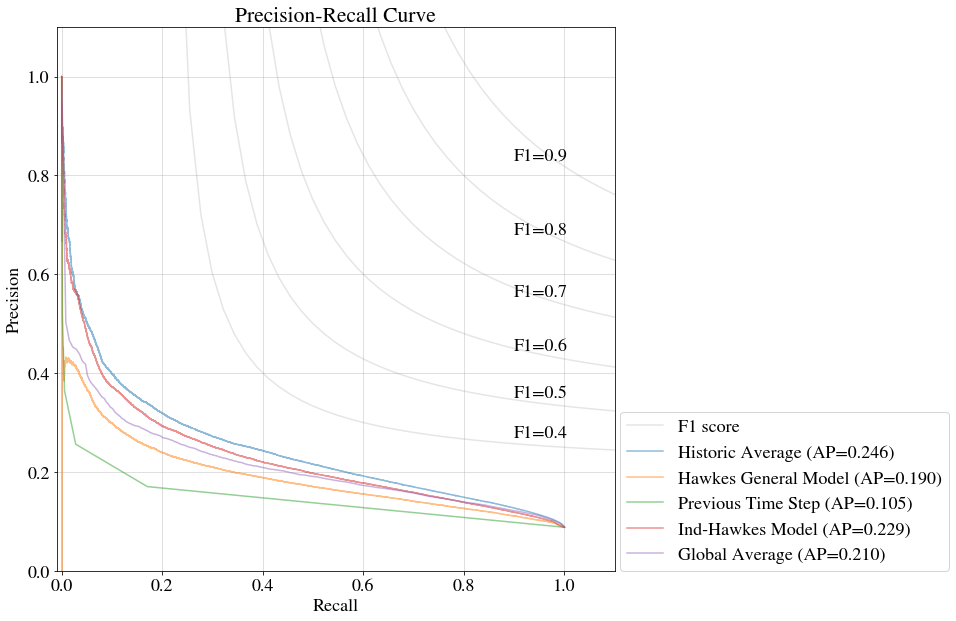

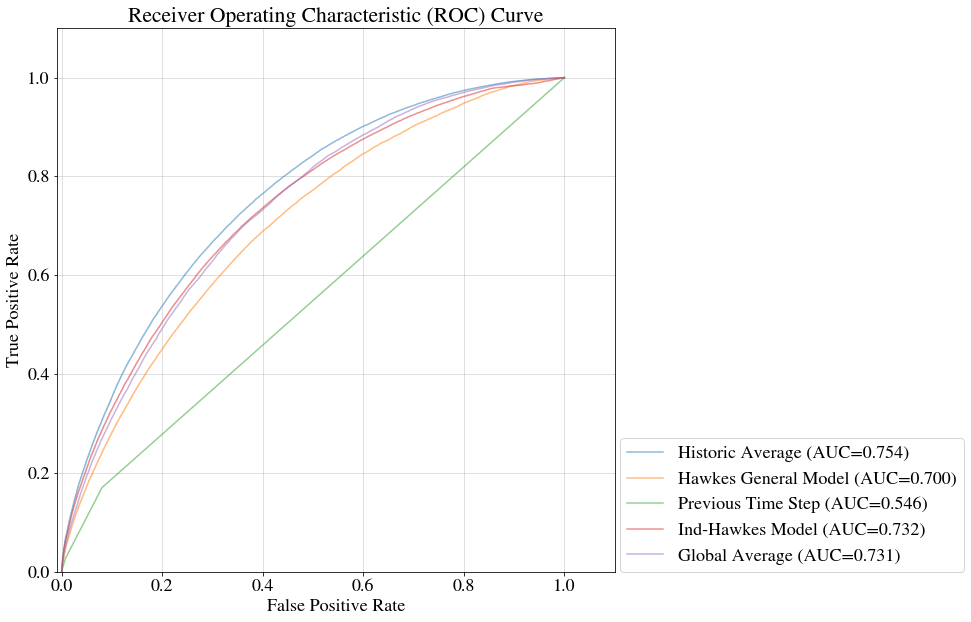

2019-11-21T15:55:19 | root | INFO | T24H-X85M-Y110M_2013-01-01_2015-01-01

2019-11-21T15:55:19 | root | INFO | 
                          RMSE       MAE   ROC AUC  Avg. Precision  Precision  \
Model Name                                                                      
Historic Average      0.195658  0.048844  0.686080        0.109543   0.135966   
Global Average        0.195663  0.048873  0.685776        0.108357   0.126715   
Ind-Hawkes Model      0.192595  0.065421  0.677452        0.106497   0.123055   
Previous Time Step    0.201242  0.047975  0.523035        0.044625   0.083511   
Hawkes General Model  0.197723  0.046742  0.500000        0.039646   0.039646   

                        Recall  F1 Score  Accuracy  Matthews Corrcoef  
Model Name                                                             
Historic Average      0.228323  0.170437  0.911882           0.131832  
Global Average        0.254379  0.169164  0.900935           0.131215  
Ind-Hawkes Model      0.250927  

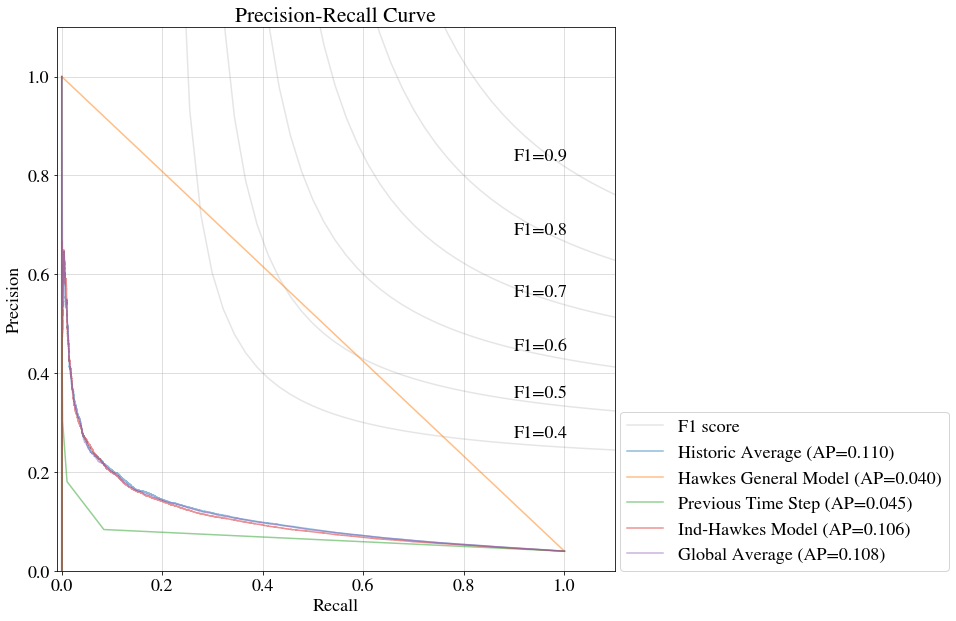

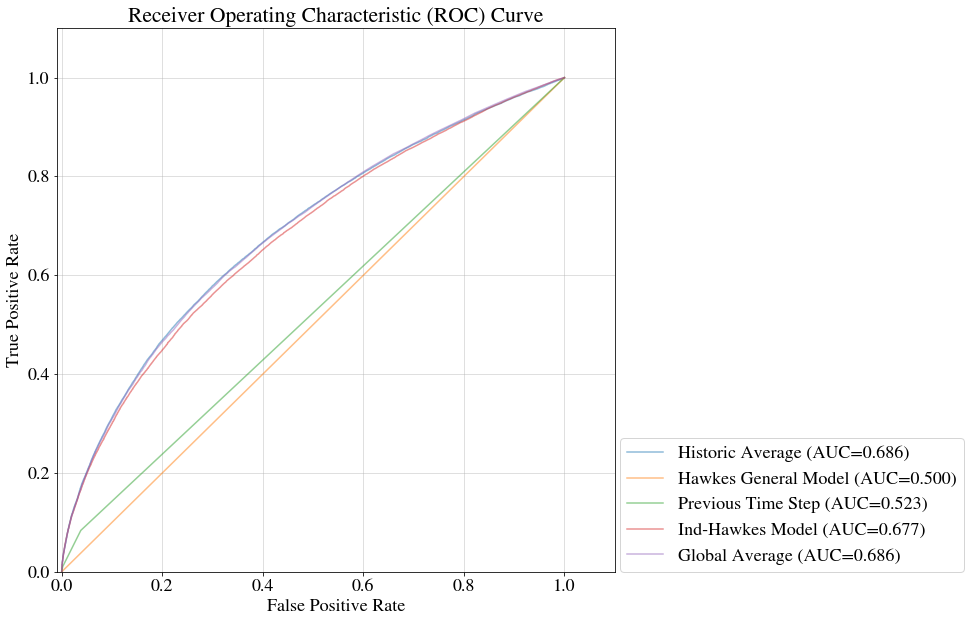

2019-11-21T15:55:21 | root | INFO | T1H-X1700M-Y1760M_2013-01-01_2015-01-01

2019-11-21T15:55:21 | root | INFO | 
                          RMSE       MAE   ROC AUC  Avg. Precision  Precision  \
Model Name                                                                      
Historic Average      0.303039  0.128158  0.755682        0.268672   0.244779   
Ind-Hawkes Model      0.302050  0.131107  0.742548        0.259317   0.240920   
Hawkes General Model  0.306032  0.127202  0.728312        0.238383   0.225246   
Global Average        0.305278  0.130063  0.731534        0.225963   0.211831   
Previous Time Step    0.319286  0.124733  0.552144        0.125175   0.196259   

                        Recall  F1 Score  Accuracy  Matthews Corrcoef  
Model Name                                                             
Historic Average      0.503600  0.329434  0.787185           0.240860  
Ind-Hawkes Model      0.471870  0.318980  0.790848           0.227100  
Hawkes General Model  0.460010

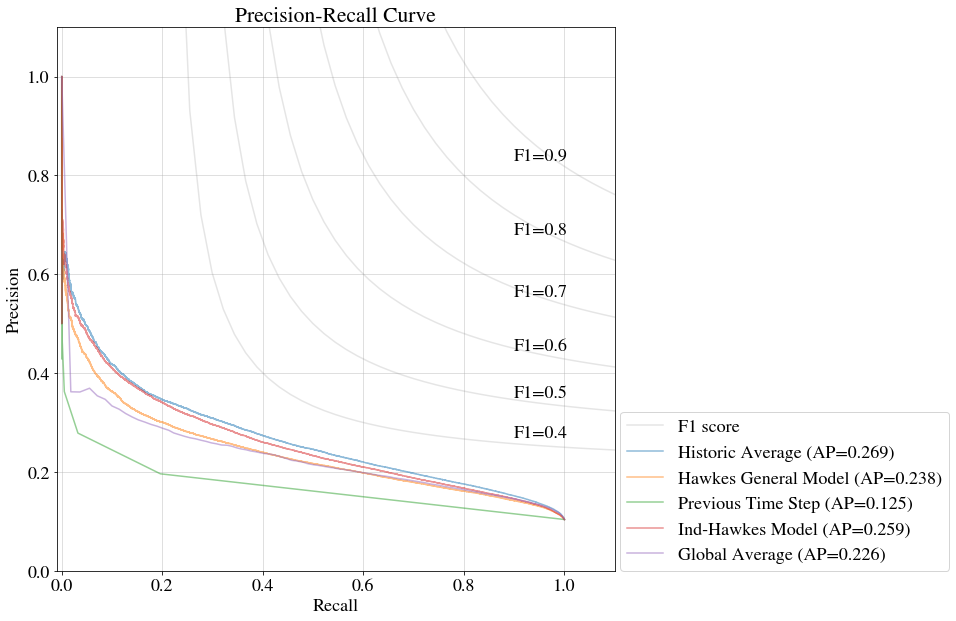

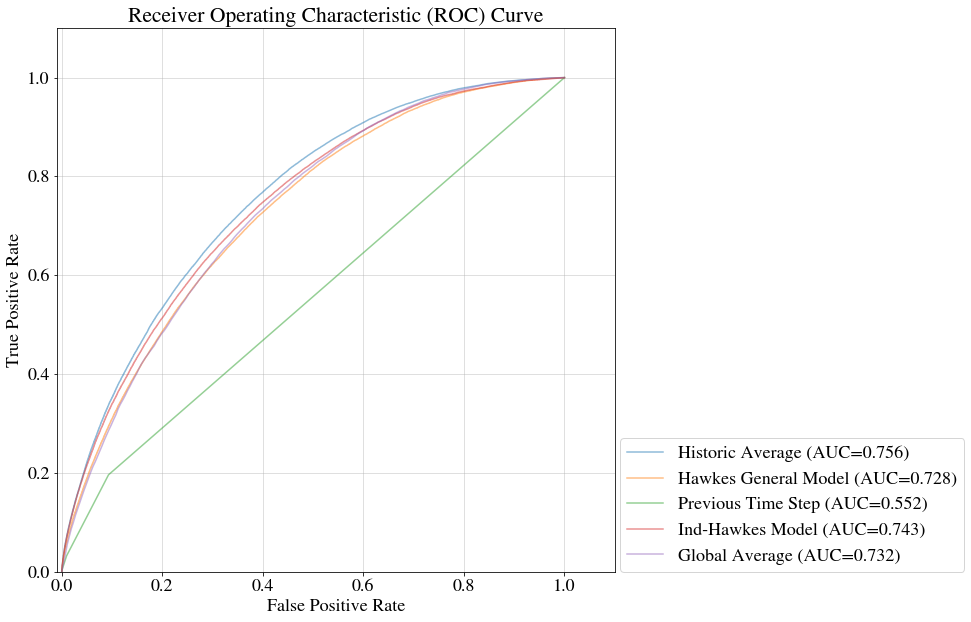

2019-11-21T15:55:23 | root | INFO | T12H-X850M-Y880M_2013-01-01_2015-01-01

2019-11-21T15:55:23 | root | INFO | 
                          RMSE       MAE   ROC AUC  Avg. Precision  Precision  \
Model Name                                                                      
Historic Average      0.465482  0.288815  0.768708        0.570248   0.449986   
Ind-Hawkes Model      0.416661  0.310532  0.755649        0.541977   0.443134   
Global Average        0.468335  0.292430  0.754147        0.537236   0.438578   
Hawkes General Model  0.476030  0.298982  0.740172        0.528419   0.430337   
Previous Time Step    0.489517  0.292910  0.581426        0.337455   0.278816   

                        Recall  F1 Score  Accuracy  Matthews Corrcoef  
Model Name                                                             
Historic Average      0.741489  0.560078  0.675228           0.351912  
Ind-Hawkes Model      0.723646  0.549670  0.669401           0.335031  
Global Average        0.728241 

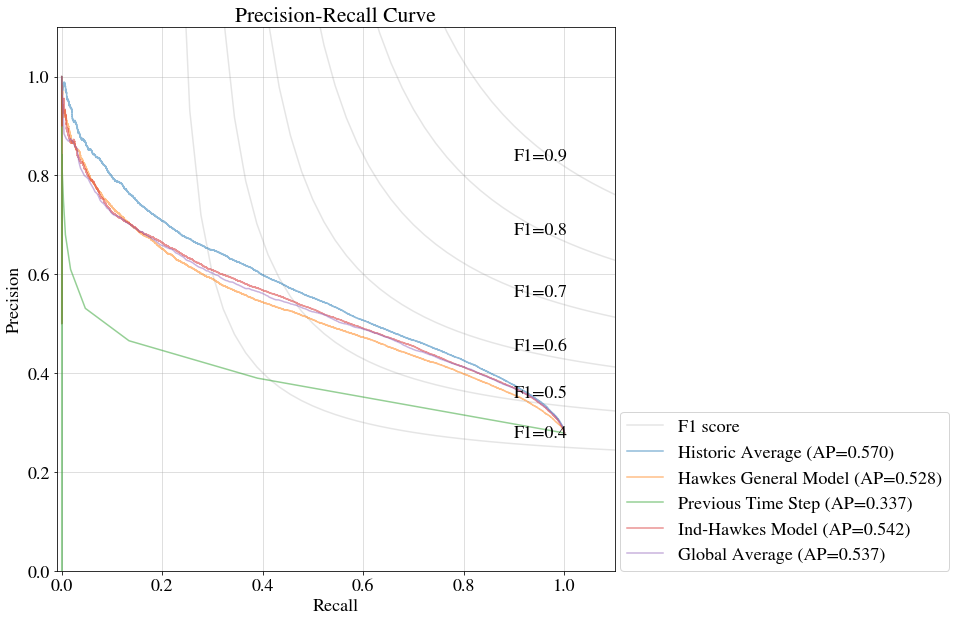

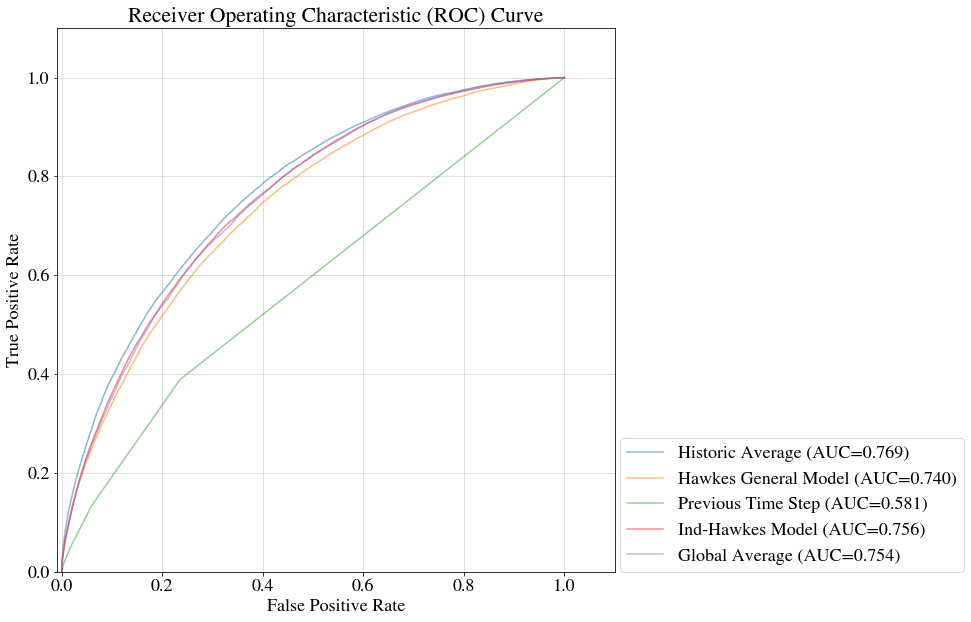

2019-11-21T15:55:25 | root | INFO | T24H-X850M-Y880M_2013-01-01_2017-01-01

2019-11-21T15:55:25 | root | INFO | 
                          RMSE       MAE   ROC AUC  Avg. Precision  Precision  \
Model Name                                                                      
Historic Average      0.568508  0.418447  0.780098        0.732258   0.605011   
Global Average        0.568439  0.418421  0.779865        0.731426   0.591743   
Ind-Hawkes Model      0.440298  0.366796  0.778737        0.730931   0.600985   
Hawkes General Model  0.610289  0.437982  0.750142        0.702393   0.569616   
Previous Time Step    0.582188  0.418037  0.645914        0.571206   0.444358   

                        Recall  F1 Score  Accuracy  Matthews Corrcoef  
Model Name                                                             
Historic Average      0.818631  0.695794  0.681919           0.397014  
Global Average        0.847433  0.696875  0.672406           0.392381  
Ind-Hawkes Model      0.823894 

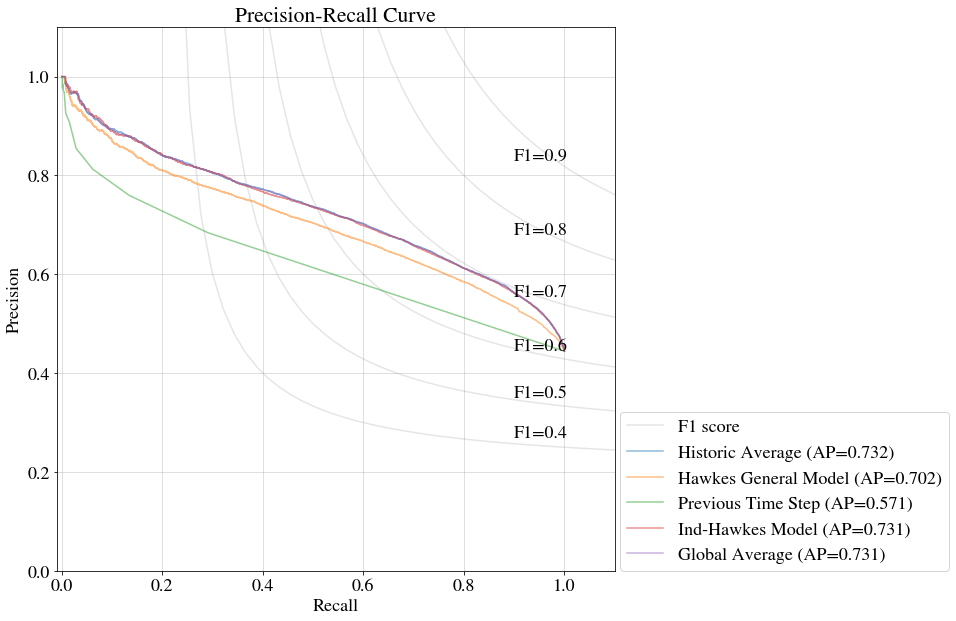

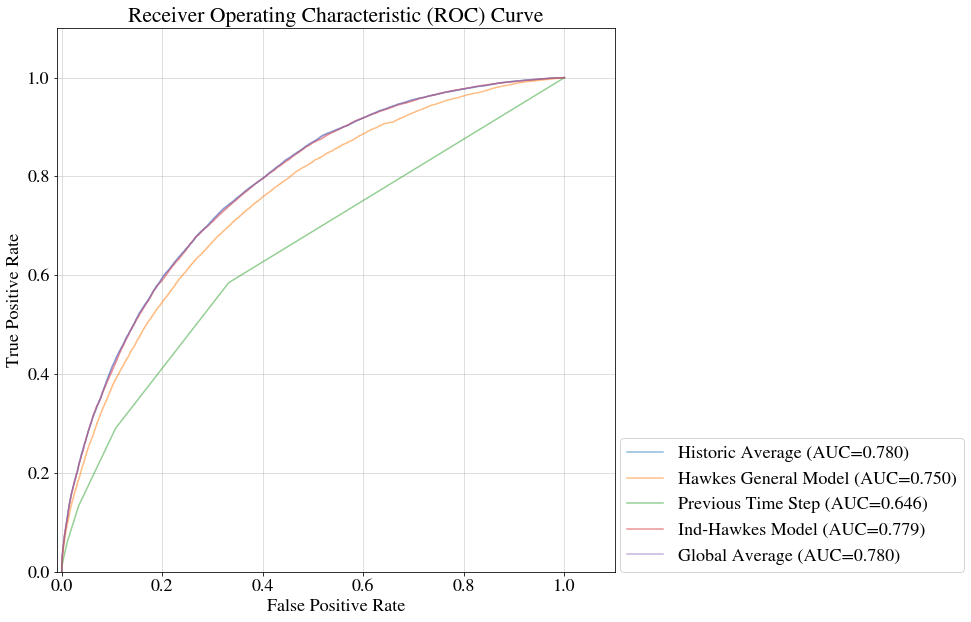

2019-11-21T15:55:27 | root | INFO | T24H-X255M-Y220M_2013-01-01_2015-01-01

2019-11-21T15:55:27 | root | INFO | 
                          RMSE       MAE   ROC AUC  Avg. Precision  Precision  \
Model Name                                                                      
Historic Average      0.285061  0.104306  0.702975        0.211051   0.207601   
Global Average        0.285044  0.104421  0.701783        0.209654   0.197510   
Ind-Hawkes Model      0.275119  0.135496  0.696804        0.207673   0.199350   
Hawkes General Model  0.285996  0.110001  0.632827        0.161489   0.158959   
Previous Time Step    0.292850  0.101824  0.537794        0.100964   0.087233   

                        Recall  F1 Score  Accuracy  Matthews Corrcoef  
Model Name                                                             
Historic Average      0.382951  0.269243  0.818665           0.186804  
Global Average        0.416129  0.267876  0.801578           0.185448  
Ind-Hawkes Model      0.397428 

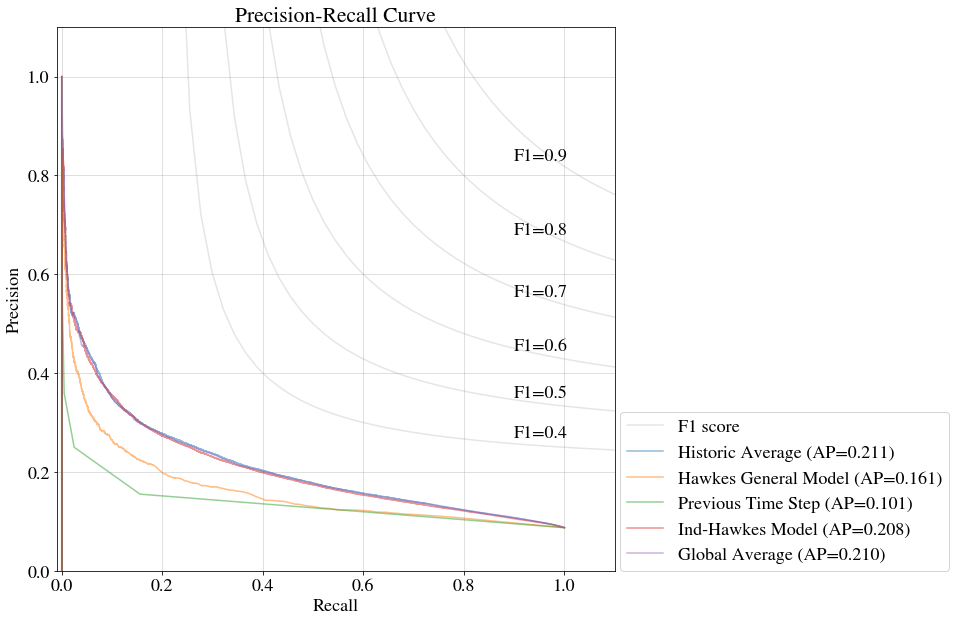

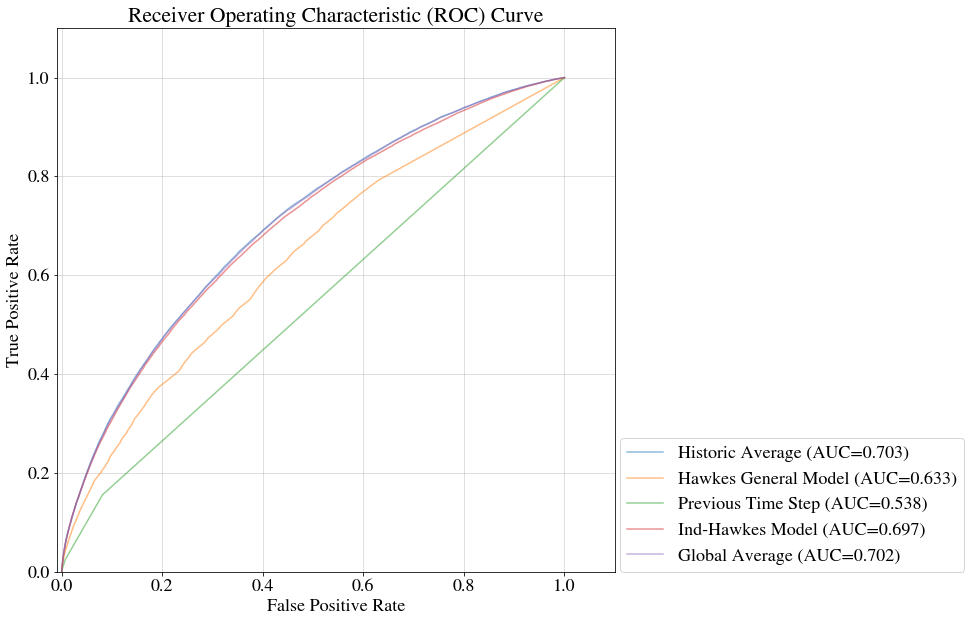

2019-11-21T15:55:28 | root | INFO | T6H-X850M-Y880M_2013-01-01_2015-01-01

2019-11-21T15:55:29 | root | INFO | 
                          RMSE       MAE   ROC AUC  Avg. Precision  Precision  \
Model Name                                                                      
Historic Average      0.369956  0.183577  0.757421        0.389893   0.328744   
ST-RESNET             0.369818  0.183563  0.751722        0.385012   0.334593   
Ind-Hawkes Model      0.354763  0.203987  0.740790        0.363636   0.303038   
Global Average        0.372429  0.186051  0.738640        0.350760   0.298332   
Hawkes General Model  0.375404  0.184262  0.713729        0.326844   0.290961   
Previous Time Step    0.387756  0.182491  0.559526        0.193322   0.161129   

                        Recall  F1 Score  Accuracy  Matthews Corrcoef  
Model Name                                                             
Historic Average      0.590978  0.422477  0.739659           0.291131  
ST-RESNET             0

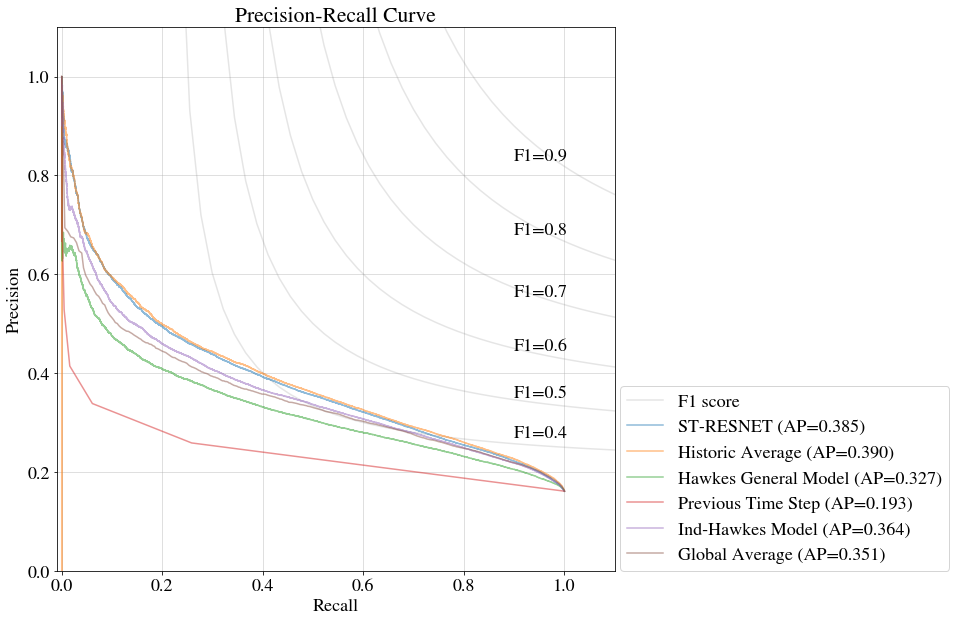

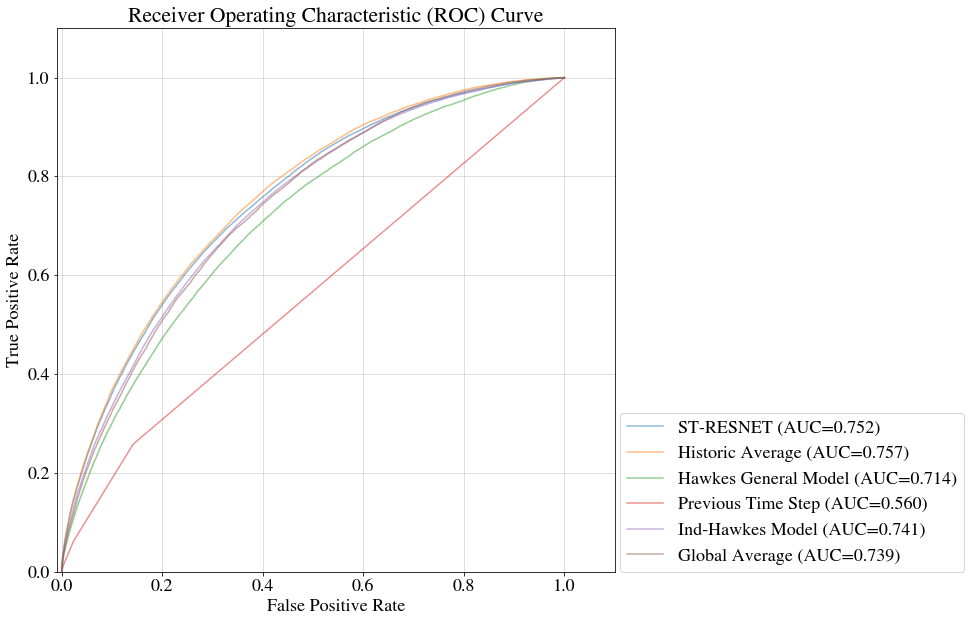

2019-11-21T15:55:32 | root | INFO | T24H-X425M-Y440M_2013-01-01_2015-01-01

2019-11-21T15:55:32 | root | INFO | 
                          RMSE       MAE   ROC AUC  Avg. Precision  Precision  \
Model Name                                                                      
Historic Average      0.401172  0.211124  0.730948        0.405234   0.338722   
Global Average        0.401071  0.211297  0.730296        0.403833   0.331204   
Ind-Hawkes Model      0.369783  0.252222  0.728220        0.402632   0.329872   
Hawkes General Model  0.402221  0.225438  0.672906        0.343329   0.294995   
Previous Time Step    0.414143  0.207293  0.569146        0.233949   0.188700   

                        Recall  F1 Score  Accuracy  Matthews Corrcoef  
Model Name                                                             
Historic Average      0.599856  0.432962  0.703509           0.271635  
Global Average        0.618894  0.431492  0.692262           0.268789  
Ind-Hawkes Model      0.617311 

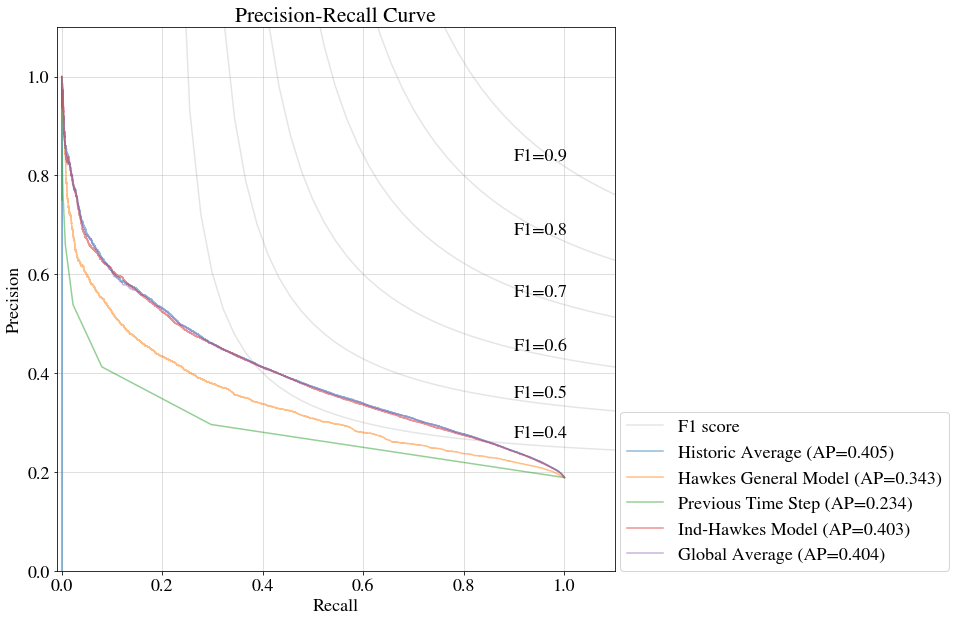

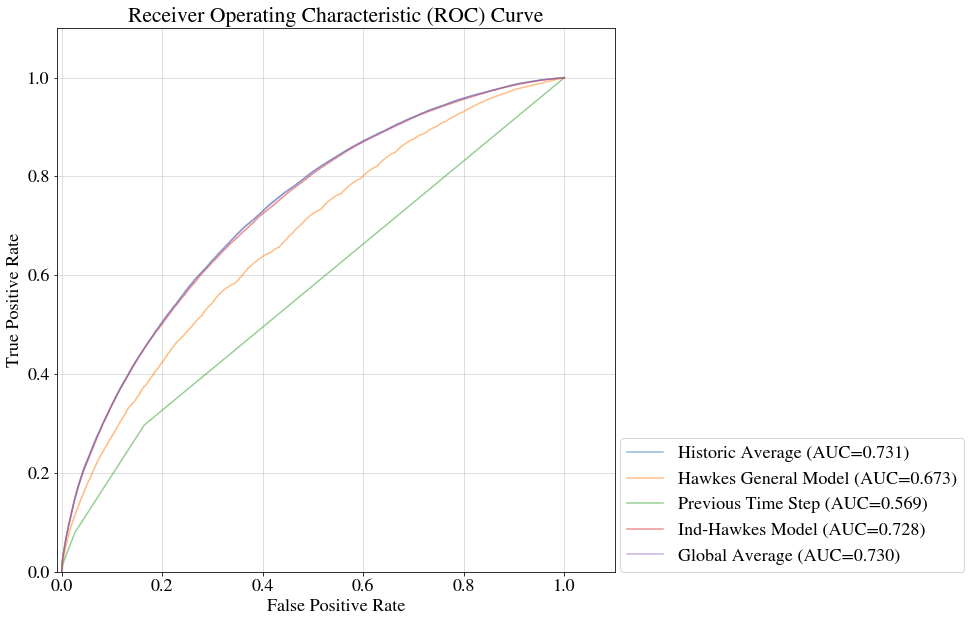

2019-11-21T15:55:34 | root | INFO | T24H-X850M-Y880M_2013-01-01_2015-01-01

2019-11-21T15:55:34 | root | INFO | 
                          RMSE       MAE   ROC AUC  Avg. Precision  Precision  \
Model Name                                                                      
Historic Average      0.553971  0.415614  0.787064        0.746747   0.599152   
Global Average        0.553563  0.415520  0.786669        0.745822   0.591271   
Ind-Hawkes Model      0.434889  0.361993  0.785569        0.744832   0.590266   
Hawkes General Model  0.563287  0.440588  0.764971        0.725511   0.581655   
Previous Time Step    0.574001  0.415492  0.653737        0.585656   0.448804   

                        Recall  F1 Score  Accuracy  Matthews Corrcoef  
Model Name                                                             
Historic Average      0.851656  0.703431  0.677703           0.401255  
Global Average        0.865153  0.702460  0.671070           0.396162  
Ind-Hawkes Model      0.862396 

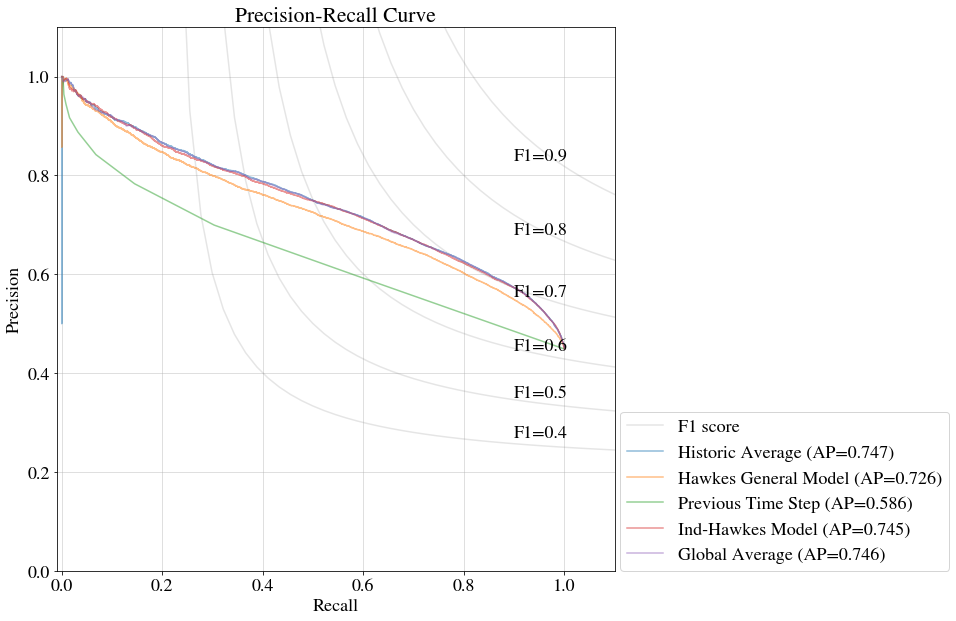

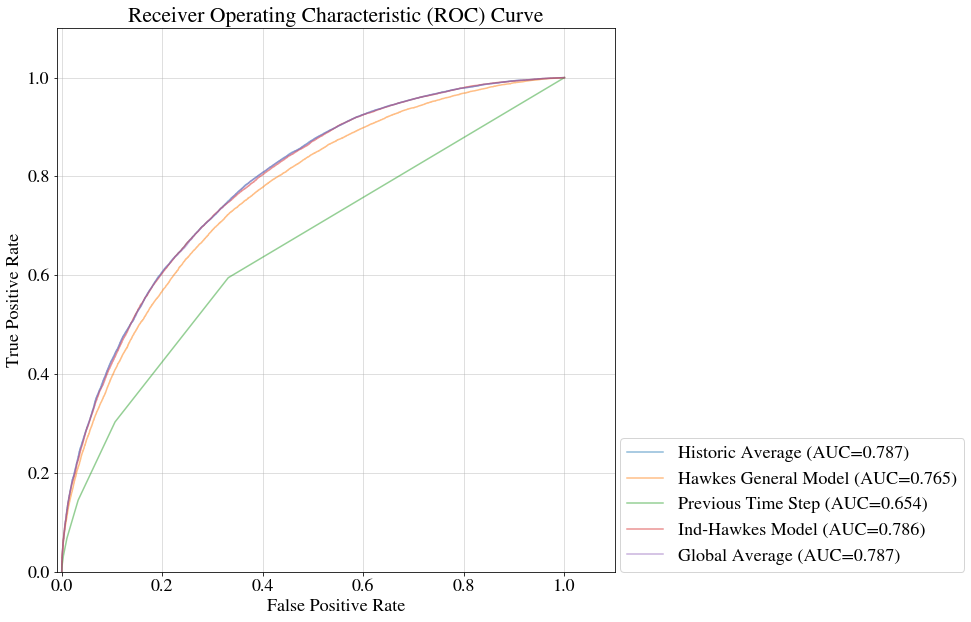

2019-11-21T15:55:35 | root | INFO | T1H-X850M-Y880M_2013-01-01_2015-01-01

2019-11-21T15:55:36 | root | INFO | 
                          RMSE       MAE   ROC AUC  Avg. Precision  Precision  \
Model Name                                                                      
Historic Average      0.174048  0.041465  0.747532        0.101228   0.115411   
Ind-Hawkes Model      0.174312  0.041220  0.710275        0.090832   0.110284   
Global Average        0.174561  0.041751  0.727132        0.082813   0.095176   
Hawkes General Model  0.174904  0.040787  0.681687        0.069977   0.086382   
Previous Time Step    0.182553  0.040181  0.522583        0.035261   0.075180   

                        Recall  F1 Score  Accuracy  Matthews Corrcoef  
Model Name                                                             
Historic Average      0.257538  0.159393  0.914352           0.132057  
Ind-Hawkes Model      0.214957  0.145777  0.920571           0.115325  
Global Average        0.275203  

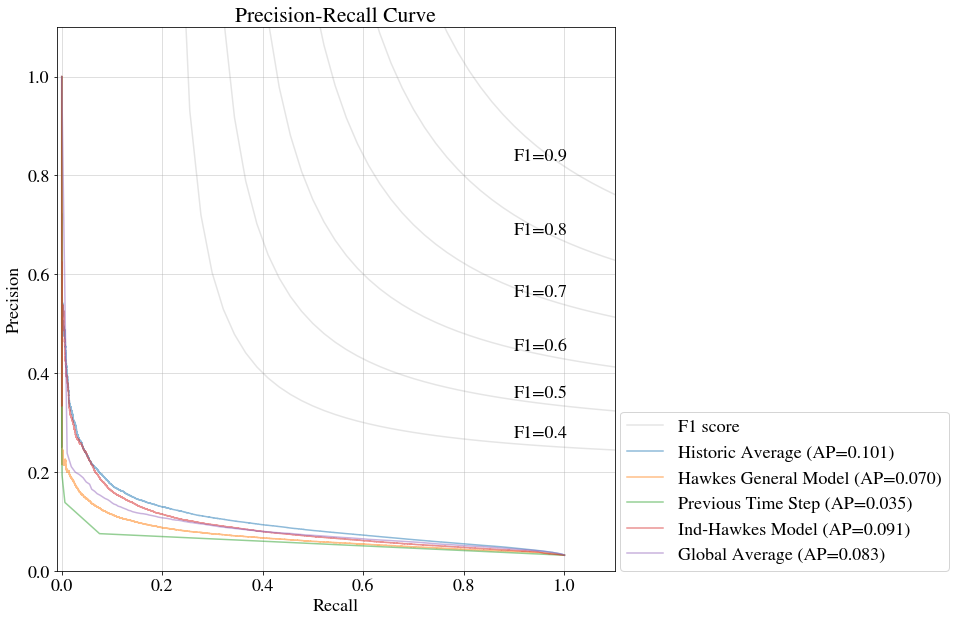

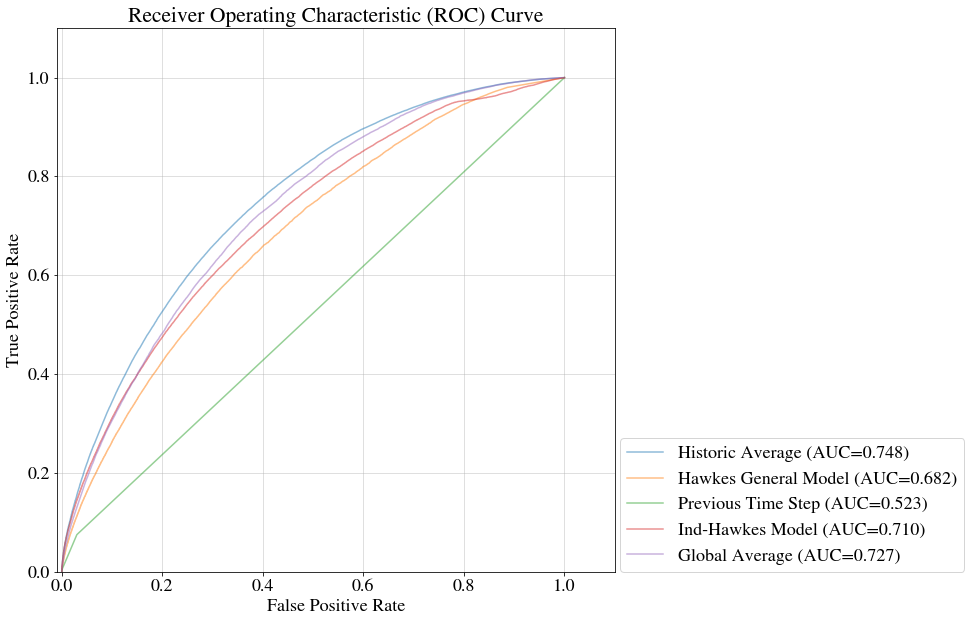

In [6]:
# data_path = conf.model_path[:conf.model_path.find("models")]
for data_sub_path in data_sub_paths:
    log.info(f"{data_sub_path}\n")
    data_path = f"./data/processed/{data_sub_path}/"

    compare_models(data_path)

In [11]:
df = get_all_metrics()
df

Model  dt    dx    dy  start_date   stop_date       MAE  \
10      Historic Average  24   850   880  2013-01-01  2017-01-01  0.420800   
14        Global Average  24   850   880  2013-01-01  2017-01-01  0.420775   
13      Ind-Hawkes Model  24   850   880  2013-01-01  2017-01-01  0.367043   
11  Hawkes General Model  24   850   880  2013-01-01  2017-01-01  0.438873   
12    Previous Time Step  24   850   880  2013-01-01  2017-01-01  0.420469   
15      Historic Average  24   425   440  2013-01-01  2017-01-01  0.201424   
18      Ind-Hawkes Model  24   425   440  2013-01-01  2017-01-01  0.242405   
19        Global Average  24   425   440  2013-01-01  2017-01-01  0.201455   
16  Hawkes General Model  24   425   440  2013-01-01  2017-01-01  0.201747   
17    Previous Time Step  24   425   440  2013-01-01  2017-01-01  0.199237   
28      Ind-Hawkes Model  24   255   220  2013-01-01  2017-01-01  0.126706   
25      Historic Average  24   255   220  2013-01-01  2017-01-01  0.096924   
29        Global Average  24   255   220  2013-01-01  2017-01-01  0.096949   
26  Hawkes General Model  24   255   220  2013-01-01  2017-01-01  0.098522   
27    Previous Time Step  24   255   220  2013-01-01  2017-01-01  0.095486   
5       Historic Average  24    85   110  2013-01-01  2017-01-01  0.045725   
8       Ind-Hawkes Model  24    85   110  2013-01-01  2017-01-01  0.062263   
9         Global Average  24    85   110  2013-01-01  2017-01-01  0.045719   
7     Previous Time Step  24    85   110  2013-01-01  2017-01-01  0.045507   
6   Hawkes General Model  24    85   110  2013-01-01  2017-01-01  0.051735   
30      Historic Average  12   850   880  2013-01-01  2017-01-01  0.284863   
33      Ind-Hawkes Model  12   850   880  2013-01-01  2017-01-01  0.306327   
34        Global Average  12   850   880  2013-01-01  2017-01-01  0.287101   
31  Hawkes General Model  12   850   880  2013-01-01  2017-01-01  0.285839   
32    Previous Time Step  12   850   880  2013-01-01  2017-01-01  0.287400   
20      Historic Average   6   850   880  2013-01-01  2017-01-01  0.174459   
23      Ind-Hawkes Model   6   850   880  2013-01-01  2017-01-01  0.196650   
24        Global Average   6   850   880  2013-01-01  2017-01-01  0.175758   
21  Hawkes General Model   6   850   880  2013-01-01  2017-01-01  0.171221   
22    Previous Time Step   6   850   880  2013-01-01  2017-01-01  0.174045   
0       Historic Average   1  1700  1760  2013-01-01  2017-01-01  0.115530   
3       Ind-Hawkes Model   1  1700  1760  2013-01-01  2017-01-01  0.120553   
1   Hawkes General Model   1  1700  1760  2013-01-01  2017-01-01  0.115534   
4         Global Average   1  1700  1760  2013-01-01  2017-01-01  0.116342   
2     Previous Time Step   1  1700  1760  2013-01-01  2017-01-01  0.114004   

        RMSE   ROC AUC  Avg. Precision  Precision    Recall  F1 Score  \
10  0.572850  0.780020        0.732161   0.602188  0.824669  0.696084   
14  0.572785  0.779824        0.731348   0.595091  0.840814  0.696928   
13  0.440396  0.778644        0.730800   0.601035  0.824992  0.695427   
11  0.612081  0.747493        0.699312   0.570855  0.826865  0.675414   
12  0.585714  0.638872        0.551308   0.444358  1.000000  0.615302   
15  0.404222  0.724239        0.387803   0.331032  0.568350  0.418381   
18  0.369121  0.721960        0.386764   0.322792  0.595151  0.418566   
19  0.404216  0.723714        0.386574   0.323375  0.591437  0.418131   
16  0.410653  0.652874        0.311993   0.244397  0.716310  0.364448   
17  0.411332  0.564535        0.219742   0.183744  1.000000  0.310445   
28  0.270753  0.695080        0.201326   0.191432  0.390051  0.256820   
25  0.281573  0.699529        0.200813   0.202440  0.352217  0.257106   
29  0.281575  0.698805        0.199464   0.189847  0.392093  0.255826   
26  0.284096  0.549794        0.101060   0.130314  0.248565  0.170986   
27  0.286331  0.536301        0.095123   0.083706  1.000000  0.154482   
5   0.194834  0.678568        0.106242   0

--------


## [Hawkes Model](https://x-datainitiative.github.io/tick/modules/generated/tick.hawkes.HawkesSumExpKern.html)
does support multi variate but we are only using univariate for now
### Data Analysis Hawks-proces using the EM kernel